# <center>Loan Default Classification Analysis</center>

<a id="table_of_content"></a>
### Table of Contents

1. [Introduction](#introduction)
2. [Import Libraries and Dataset](#import-libraries)
3. [Load and Explore the Data](#load-and-explore-the-data)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-eda)
5. [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing)
6. [Model Building](#model-building)
7. [Model Evaluation](#model-evaluation)
8. [Feature Engineering](#feature-engineering)
6. [Model Building After Feature Engineering](#model-building-after-fe)
7. [Model Evaluation After Feature Engineering](#model-evaluation-after-fe)
9. [Conclusion and Recommendations](#conclusion-and-recommendations)
10. [Appendix](#appendix)

<a id="introduction"></a>
### Introduction <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In the financial industry, predicting whether a borrower will default on a loan is a critical task for lenders. Loan defaults can lead to significant financial losses, making it essential to identify high-risk borrowers early in the lending process. By leveraging data analytics and machine learning, we can build predictive models to assess the likelihood of loan defaults, enabling lenders to make informed decisions and mitigate risks.

For this project, I will be using this <a href='https://www.kaggle.com/datasets/prakashraushan/loan-dataset/data'>Loan Default</a> dataset found in Kaggle. The dataset includes over 32 556 loan records and features such as loan amount, interest rate, borrower income, employment length, credit score, and loan status, etc... The goal of this analysis is to build a classification model that predicts whether a borrower will default on their loan based on these features.

By analyzing this dataset, I aim to:

- Identify key factors that contribute to loan defaults.
- Develop a machine learning model to predict loan defaults accurately.
- Provide actionable insights to help lenders reduce financial risks and improve decision-making.

This project will involve data cleaning, exploratory data analysis (EDA), feature engineering, and model building, culminating in a classification model that can be used to assess borrower risk.

<a id="import-libraries"></a>
### Import Libraries and Dataset <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer

from imblearn.over_sampling import SMOTE

import os
import joblib
import pickle
import warnings
from lightgbm import log_evaluation

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import optuna
from optuna.samplers import TPESampler, CmaEsSampler 
from optuna.pruners import MedianPruner, PercentilePruner

import math

from functools import partial
import time
import logging

In [4]:
# Disable all logs globally
logging.disable(logging.CRITICAL)
xgb.set_config(verbosity=0)
lgb.basic._log_info = lambda *args, **kwargs: None
lgb.basic._log_warning = lambda *args, **kwargs: None
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [5]:
df = pd.read_csv('dataset\\LoanDataset.csv')

<a id="load-and-explore-the-data"></a>
### Load and Explore the Data <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [6]:
# Display first rows of the dataset
df.head()

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
0,1.0,22,59000,RENT,123.0,PERSONAL,C,"£35,000.00",16.02,10,Y,3,DEFAULT
1,2.0,21,9600,OWN,5.0,EDUCATION,A,"£1,000.00",11.14,1,NaN,2,NO DEFAULT
2,3.0,25,9600,MORTGAGE,1.0,MEDICAL,B,"£5,500.00",12.87,5,N,3,DEFAULT
3,4.0,23,65500,RENT,4.0,MEDICAL,B,"£35,000.00",15.23,10,N,2,DEFAULT
4,5.0,24,54400,RENT,8.0,MEDICAL,B,"£35,000.00",14.27,10,Y,4,DEFAULT


In [7]:
# Check the shape of the dataset
df.shape

(32586, 13)

In [8]:
# Check dataframe info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32586 entries, 0 to 32585
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   customer_id          32583 non-null  float64
 1   customer_age         32586 non-null  int64  
 2   customer_income      32586 non-null  object 
 3   home_ownership       32586 non-null  object 
 4   employment_duration  31691 non-null  float64
 5   loan_intent          32586 non-null  object 
 6   loan_grade           32586 non-null  object 
 7   loan_amnt            32585 non-null  object 
 8   loan_int_rate        29470 non-null  float64
 9   term_years           32586 non-null  int64  
 10  historical_default   11849 non-null  object 
 11  cred_hist_length     32586 non-null  int64  
 12  Current_loan_status  32582 non-null  object 
dtypes: float64(3), int64(3), object(7)
memory usage: 3.2+ MB


We notice that there are missing elements that's why we need to check the dataframe with the method `info()`

In [9]:
# Check for the presence of missing values
df.isnull().sum()

customer_id                3
customer_age               0
customer_income            0
home_ownership             0
employment_duration      895
loan_intent                0
loan_grade                 0
loan_amnt                  1
loan_int_rate           3116
term_years                 0
historical_default     20737
cred_hist_length           0
Current_loan_status        4
dtype: int64

The missing elements are in these columns:
- `customer_id` (Not important since we're gonna drop this column later)
- `employment_duration`
- `loan_amnt` (I'm gonna drop that row since it's just one row and it's insignificant number in our dataset)
- `loan_int_rate`
- `historical_default`
- `Current_loan_status` (These missing elements will be used for predictions after building the models)

Verifying duplicates:

In [10]:
display(df.duplicated().sum())

6

Deleting duplicates

In [11]:
# Check duplicate rows
duplicated_rows = df[df.duplicated(keep=False)]
duplicated_rows

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,Current_loan_status
322,323.0,25,120000,RENT,6.0,MEDICAL,A,"£1,000,000.00",10.74,10,N,2,DEFAULT
323,323.0,25,120000,RENT,6.0,MEDICAL,A,"£1,000,000.00",10.74,10,N,2,DEFAULT
324,324.0,23,120000,RENT,7.0,EDUCATION,A,"£25,000.00",9.99,10,NaN,2,NO DEFAULT
325,324.0,23,120000,RENT,7.0,EDUCATION,A,"£25,000.00",9.99,10,NaN,2,NO DEFAULT
14689,14688.0,21,32000,RENT,6.0,PERSONAL,B,"£15,000.00",15.27,1,Y,3,DEFAULT
14690,14689.0,22,38000,RENT,6.0,PERSONAL,A,"£15,000.00",7.88,2,N,3,DEFAULT
14691,14688.0,21,32000,RENT,6.0,PERSONAL,B,"£15,000.00",15.27,1,Y,3,DEFAULT
14692,14689.0,22,38000,RENT,6.0,PERSONAL,A,"£15,000.00",7.88,2,N,3,DEFAULT
30287,30284.0,47,70000,RENT,3.0,HOMEIMPROVEMENT,A,"£6,000.00",8.49,7,N,12,NO DEFAULT
30288,30285.0,44,70000,RENT,15.0,DEBTCONSOLIDATION,A,"£6,000.00",5.79,4,N,16,DEFAULT


Rename Current_loan_status column to current_loan_status.

In [12]:
df = df.rename(columns={'Current_loan_status': 'current_loan_status'})

Formating the column loan_amnt to cast it to number type

In [13]:
# Remove currency symbol and commas, then convert to numeric
df['loan_amnt'] = df['loan_amnt'].str.replace('£', '').str.replace(',', '')
df['loan_amnt'] = pd.to_numeric(df['loan_amnt'])

<a id="exploratory-data-analysis-eda"></a>
### Exploratory Data Analysis (EDA) <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [14]:
df.describe(include='all')

,customer_id,customer_age,customer_income,home_ownership,employment_duration,loan_intent,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,current_loan_status
count,32583.000000,32586.000000,32586,32586,31691.000000,32586,32586,3.258500e+04,29470.000000,32586.000000,11849,32586.000000,32582
unique,NaN,NaN,4299,4,NaN,6,5,NaN,NaN,NaN,2,NaN,2
top,NaN,NaN,60000,RENT,NaN,EDUCATION,A,NaN,NaN,NaN,Y,NaN,NO DEFAULT
freq,NaN,NaN,1046,16451,NaN,6454,15661,NaN,NaN,NaN,6128,NaN,25742
mean,16289.497806,27.732769,NaN,NaN,4.790161,NaN,NaN,9.756247e+03,11.011553,4.761738,NaN,5.804026,NaN
std,9405.919628,6.360528,NaN,NaN,4.142746,NaN,NaN,2.177185e+04,3.240440,2.471107,NaN,4.055078,NaN
min,1.000000,3.000000,NaN,NaN,0.000000,NaN,NaN,5.000000e+02,5.420000,1.000000,NaN,2.000000,NaN
25%,8144.500000,23.000000,NaN,NaN,2.000000,NaN,NaN,5.000000e+03,7.900000,3.000000,NaN,3.000000,NaN
50%,16288.000000,26.000000,NaN,NaN,4.000000,NaN,NaN,8.000000e+03,10.990000,4.000000,NaN,4.000000,NaN
75%,24433.500000,30.000000,NaN,NaN,7.000000,NaN,NaN,1.220000e+04,13.470000,7.000000,NaN,8.000000,NaN


**Data Quality Issues:**

- Unrealistic values in customer_age (e.g., age 3 and 144) and employment_duration (e.g., 123 years).

- Missing values in employment_duration, loan_int_rate, and historical_default.

**Key Insights:**

- customer_age: Mean = 27.73, but has unrealistic min/max values.

- loan_int_rate: Mean = 11.01%, with rates ranging from 5.42% to 23.22%.

- cred_hist_length: Mean = 5.80 years, most between 3–8 years.

- home_ownership: Most customers rent (16,451 occurrences).

- loan_intent: "EDUCATION" is the most common reason (6,454 occurrences).

- loan_grade: "A" is the most frequent grade (15,661 occurrences).

- Current_loan_status: Imbalanced target variable (25,742 "NO DEFAULT" vs. fewer defaults).

**What should be done?**

- Clean unrealistic values in customer_age and employment_duration.

- Handle missing values in employment_duration, loan_int_rate, and historical_default.

- Encode categorical columns for modeling.

- Address class imbalance in Current_loan_status.

<b>Distribution of categorical columns</b>

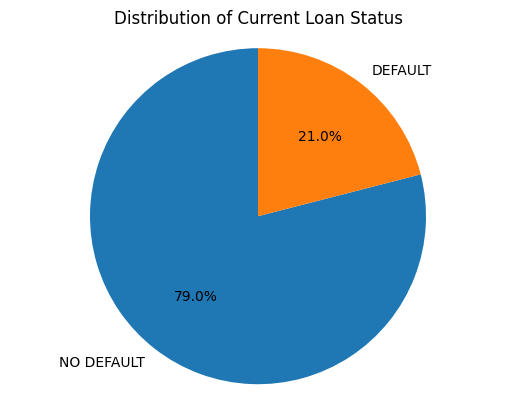

In [15]:
loan_status_counts = df['current_loan_status'].value_counts()

# Create the pie chart
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that the pie is drawn as a circle.

plt.title('Distribution of Current Loan Status')
plt.show()


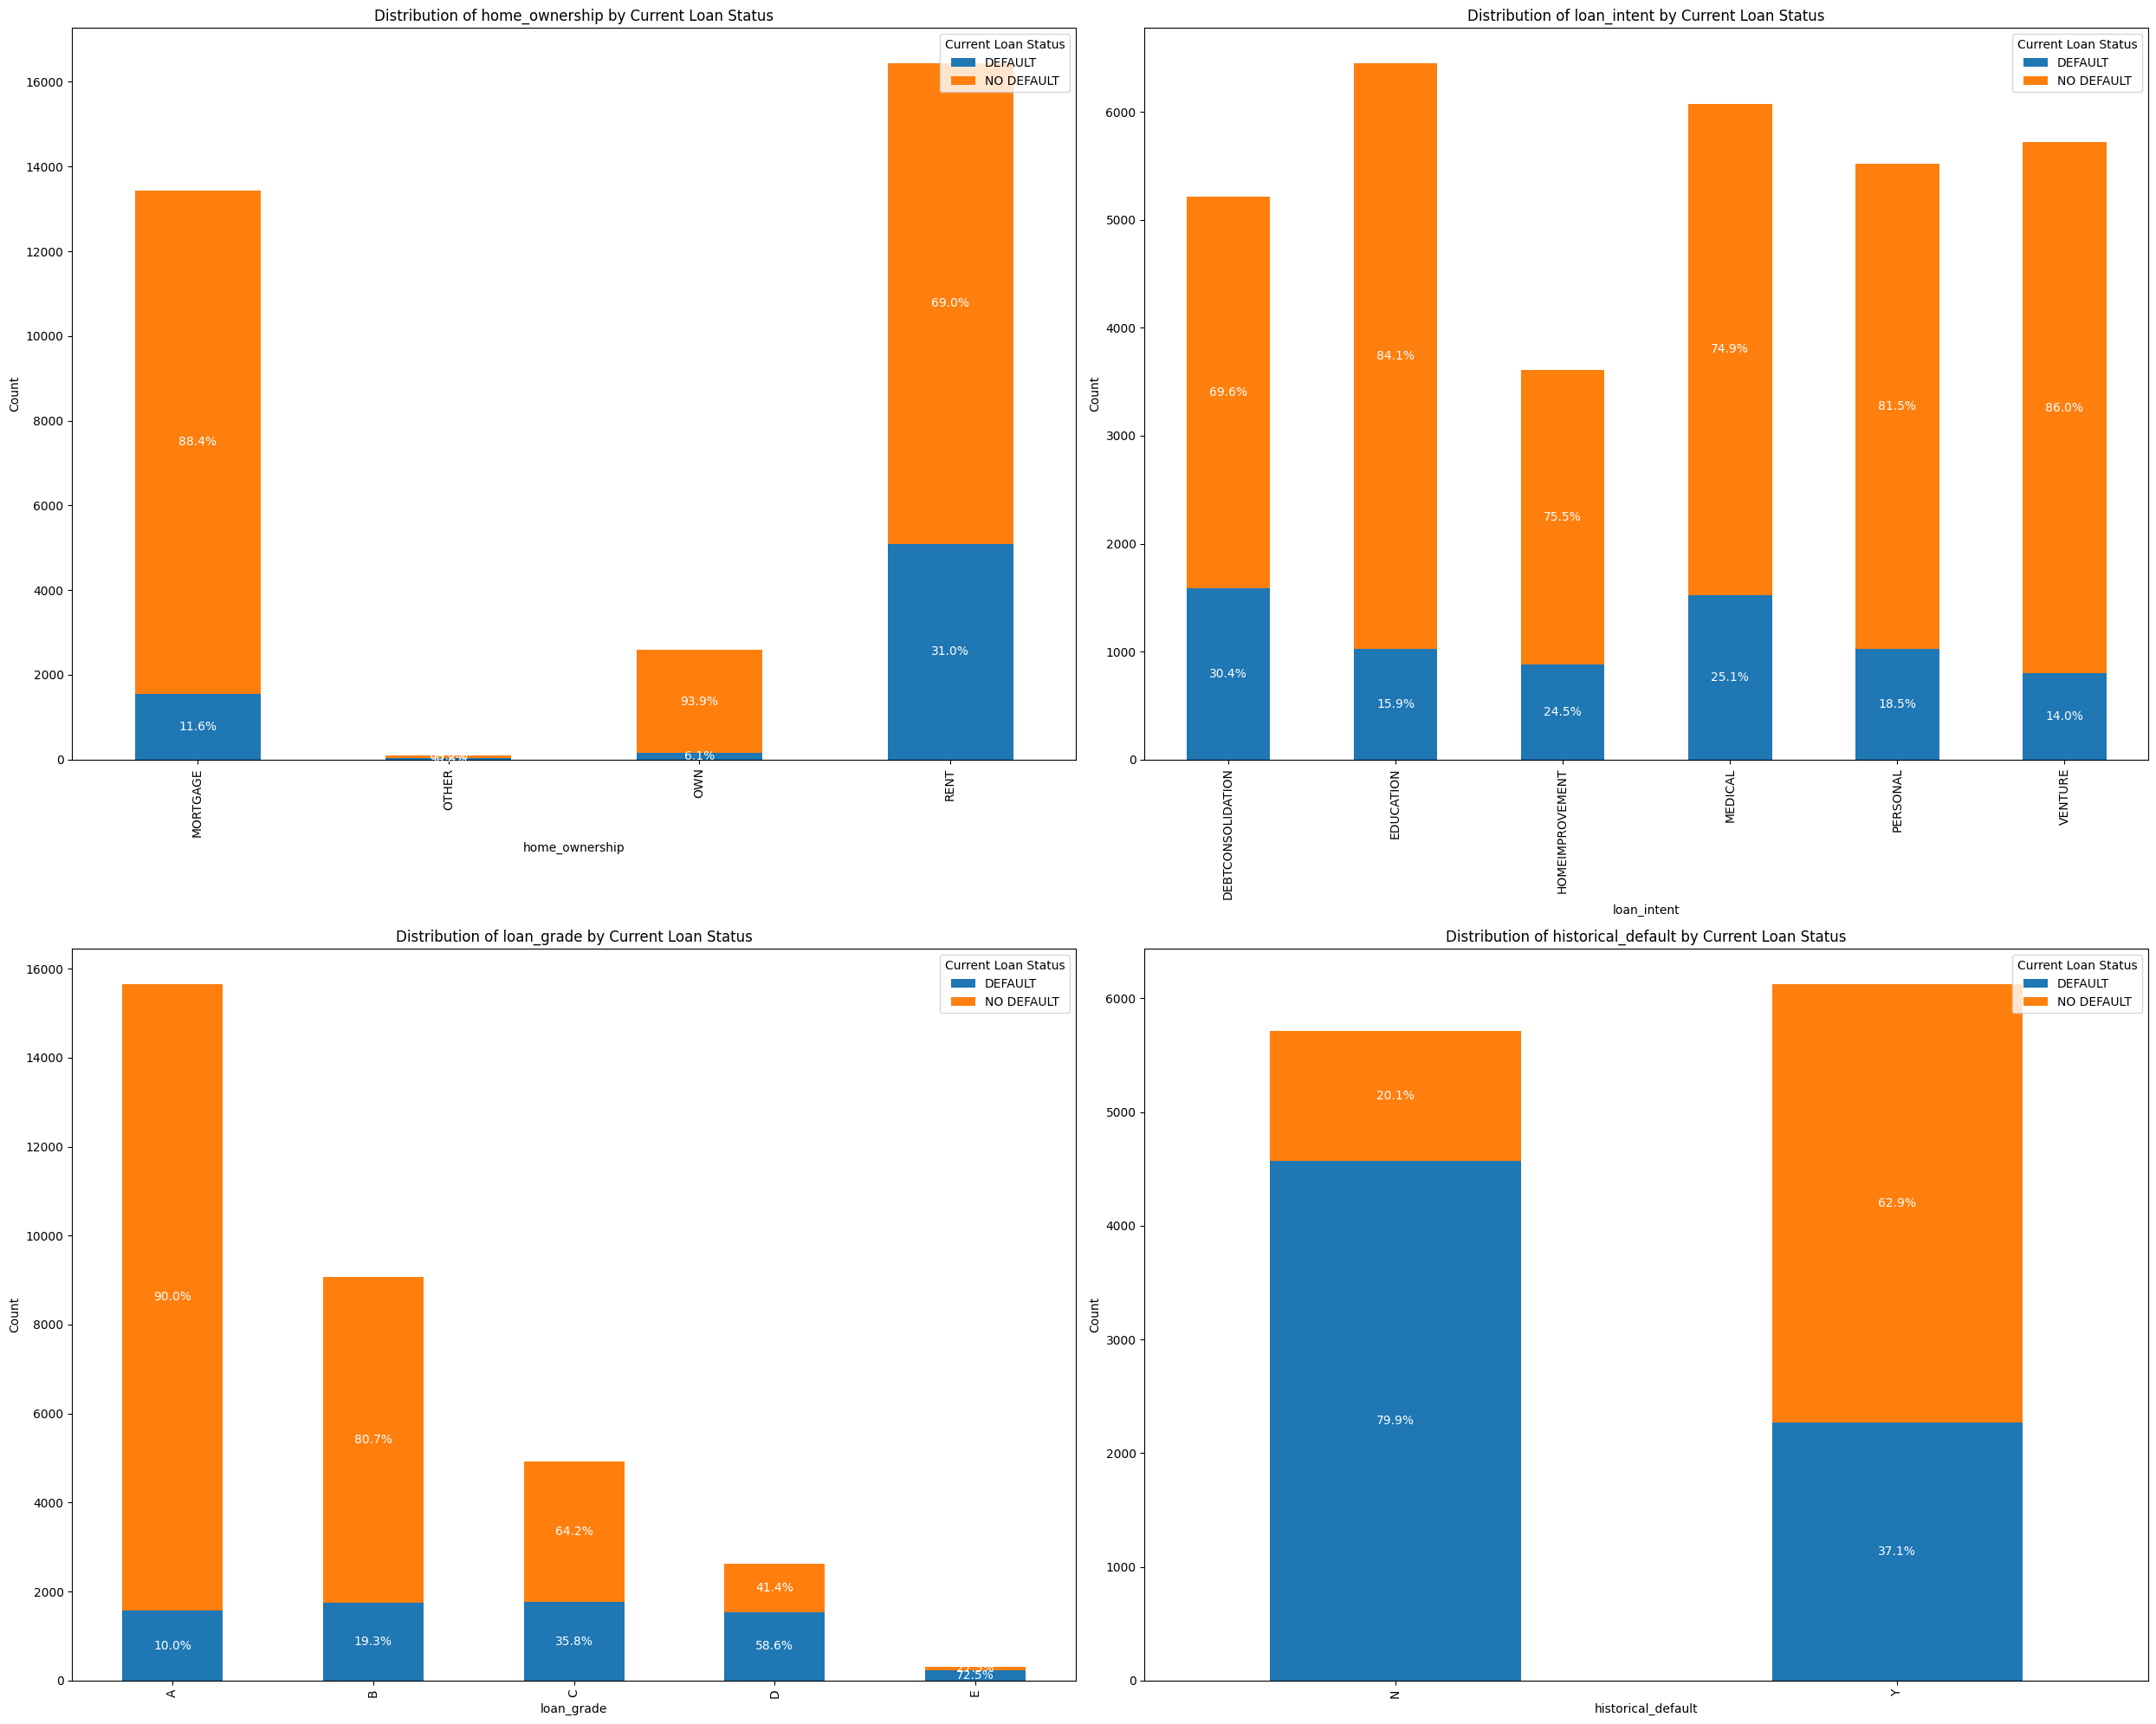

In [16]:
categorical_columns = ['home_ownership', 'loan_intent', 'loan_grade', 'historical_default']
num_columns = len(categorical_columns)
num_rows = math.ceil(num_columns / 2)

plt.figure(figsize=(25, 20))

for i, column_name in enumerate(categorical_columns, 1):
    plt.subplot(num_rows, 2, i)

    # Calculate the counts and percentages
    data = df.groupby([column_name, 'current_loan_status']).size().unstack().fillna(0)
    percentages = data.div(data.sum(axis=1), axis=0)

    # Plot the stacked bar chart with counts
    ax = data.plot(kind='bar', stacked=True, ax=plt.gca(), color=['#1f77b4', '#ff7f0e'])

    # Annotate bars with percentages
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        total = data.sum(axis=1).iloc[int(x + width / 2)]
        percentage = f'{height / total:.1%}'
        ax.annotate(percentage, (x + width / 2, y + height / 2), ha='center', va='center', fontsize=10, color='white')

    plt.title(f'Distribution of {column_name} by Current Loan Status')
    plt.ylabel('Count')
    plt.xlabel(column_name)
    plt.legend(title='Current Loan Status', loc='upper right')

plt.tight_layout()
plt.show()

The next two cells is a display of percentage of people who have default loans and non default loans of the cells that are not visible in the last visual.

In [17]:
# Filter the dataframe for 'other' value in loan_grade column
e_loan_grade = df[df['loan_grade'] == 'E']
# Display the percentage of default/no-default for 'E' value
e_grade_counts = e_loan_grade['current_loan_status'].value_counts() / e_loan_grade.shape[0] * 100

print("The percentage of defaulted loans with E loan grade is {:.2f}%".format(e_grade_counts.iloc[0]))

The percentage of defaulted loans with E loan grade is 72.46%


In [18]:
# Filter the dataframe for 'other' value in home_ownership column
other_home_ownership = df[df['home_ownership'] == 'OTHER']

# Display the percentage of default/no-default for 'other' value
other_counts = other_home_ownership['current_loan_status'].value_counts() / other_home_ownership.shape[0] * 100
print("The percentage of defaulted loans with \"Other\" in home_ownership column is {:.2f}%".format(other_counts.iloc[0]))

The percentage of defaulted loans with "Other" in home_ownership column is 69.16%


<b>Distribution of numerical columns</b>

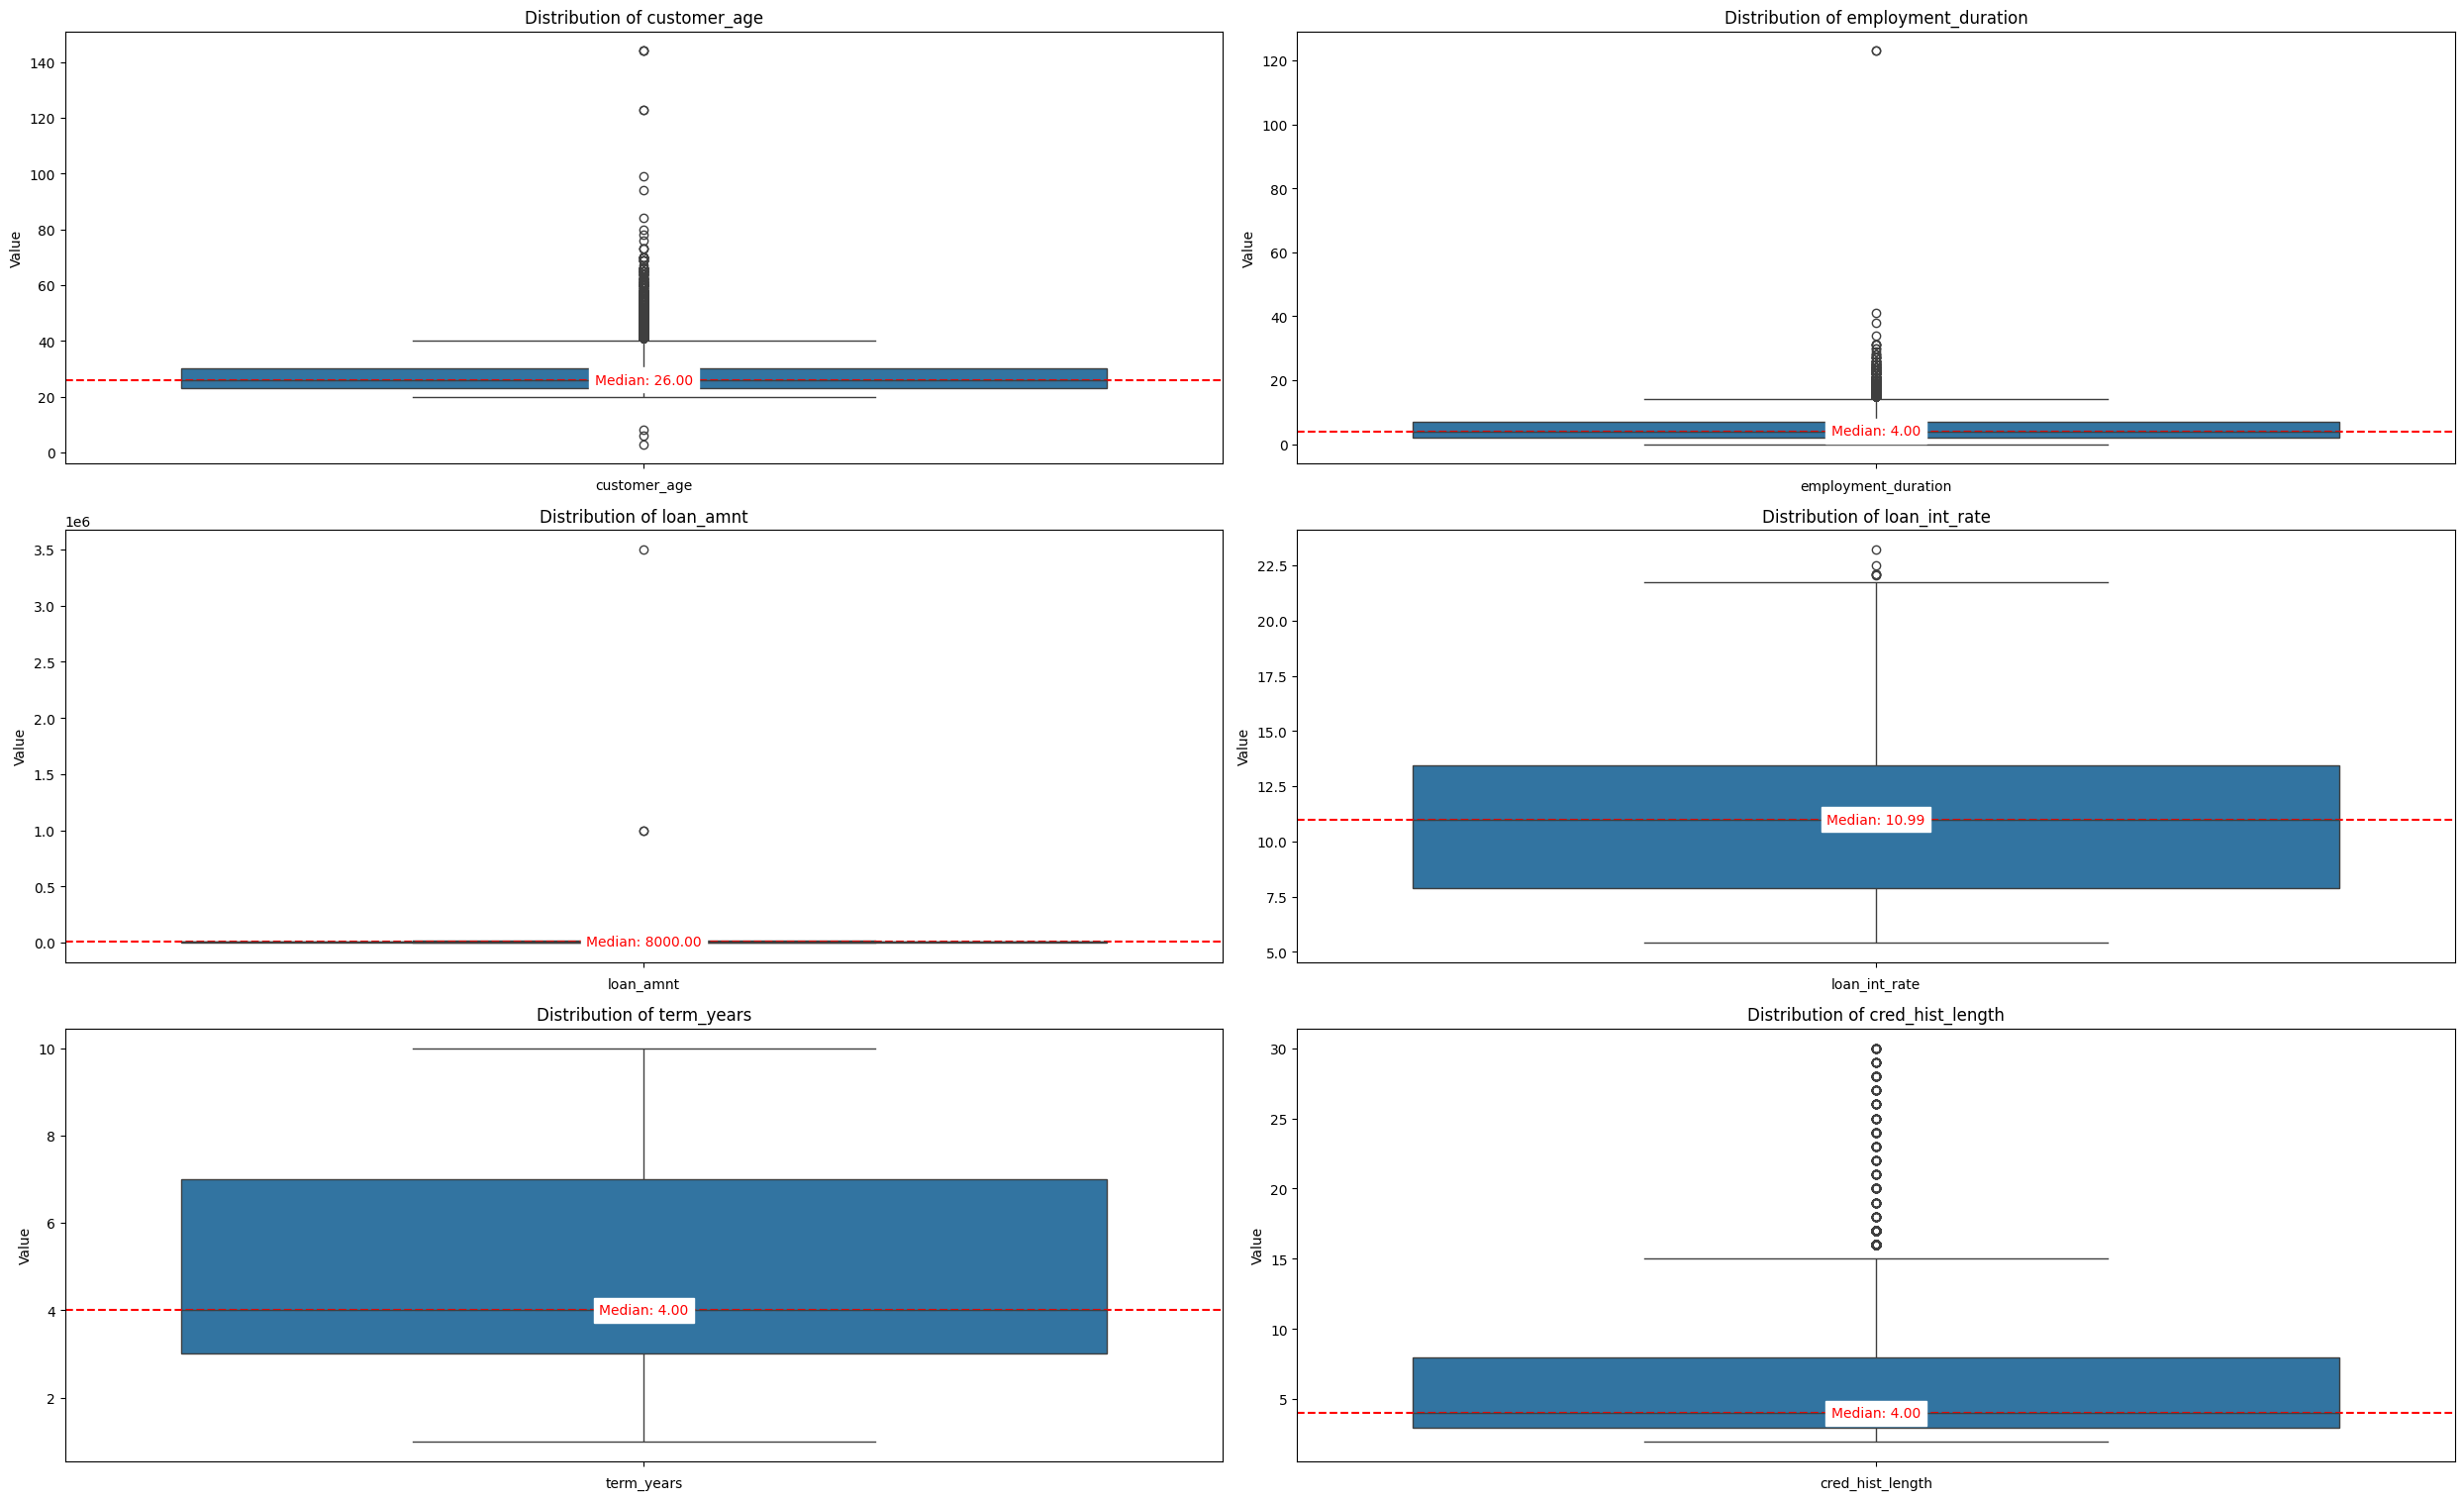

In [19]:
numerical_columns = ['customer_age', 'employment_duration', 'loan_amnt', 'loan_int_rate', 'term_years', 'cred_hist_length']

plt.figure(figsize=(25, 20))

for i, column_name in enumerate(numerical_columns, 1):
    plt.subplot(len(numerical_columns) // 2 + 1, 2, i)
    ax = sns.boxplot(data=df, y=column_name)

    # Calculate the median
    median = df[column_name].median()

    # Add the median line
    ax.axhline(median, color='r', linestyle='--')

    # Annotate the median value
    ax.annotate(f'Median: {median:.2f}', xy=(0.5, median), xycoords=('axes fraction', 'data'),
                ha='center', va='center', fontsize=10, color='red', backgroundcolor='white')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

- **Customer Age**:  
  - Median age is **26 years**.  
  - Several outliers, with extreme values exceeding **140 years**, suggesting possible data entry errors.  

- **Employment Duration**:  
  - Median duration is **4 years**.  
  - Some extreme outliers, with a few values exceeding **120 years**, indicating data inconsistencies.  

- **Loan Amount**:  
  - Median loan amount is **8,000**.  
  - Extreme outliers exist, with some values reaching **3.5 million**, indicating high variance.  

- **Loan Interest Rate**:  
  - Median interest rate is **10.99%**.  
  - Distribution appears more balanced, with some high outliers beyond **20%**.  

- **Loan Term (Years)**:  
  - Median loan term is **4 years**.  
  - Most values fall within a reasonable range, but there are some variations.  

- **Credit History Length**:  
  - Median credit history length is **4 years**.  
  - Many outliers, with some credit histories extending beyond **25 years**.  

### Observations:  
- Several features contain extreme outliers (e.g., customer age, employment duration, loan amount).  
- Potential data quality issues exist, particularly with implausible values (e.g., age > 100 years).  
- Loan amount and credit history length show a highly skewed distribution.  
- Interest rates and loan terms appear relatively well-distributed but still have some high-end variations.  

**Note:** I displayed customer_income chart in historgram because pandas treats it like an object because of missing values which will dealt with later on in [Data Cleaning and Preprocessing](#data-cleaning-and-preprocessing) section.

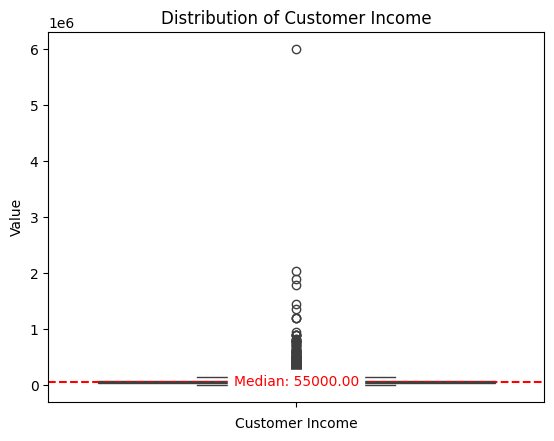

In [20]:
# Create a boxplot
ax = sns.boxplot(data=pd.DataFrame(df['customer_income'].str.replace(',', '').astype(float)) , y='customer_income')

# Calculate the median
median = df['customer_income'].str.replace(',', '').astype(float).median()

# Add the median line
ax.axhline(median, color='r', linestyle='--')

# Annotate the median value
ax.annotate(f'Median: {median:.2f}', xy=(0.5, median), xycoords=('axes fraction', 'data'),
            ha='center', va='center', fontsize=10, color='red', backgroundcolor='white')

plt.title('Distribution of Customer Income')
plt.xlabel('Customer Income')
plt.ylabel('Value')
plt.show()


From the boxplots shown above, we notice:
- Median age is 26 with outlier that consist of people below 18 years old and above 80 years old.
- Median income is 55000£. People who ear over 200000£ can be considered outliers.
- The median of professional years experience is 4 years. We notice there is one person with 140 years experience.
- The median of loan amount is 8000. Loan amounts above 100000£ can be considered as outliers.
- The median loan interest is 11%. Interests above 21% can be considered as outliers.
- The median payment term is 4 years. No outliers detected.
- The median of credit history length is 4 years. Values above 15 years can bbe considered as outliers.

**Pairplots**

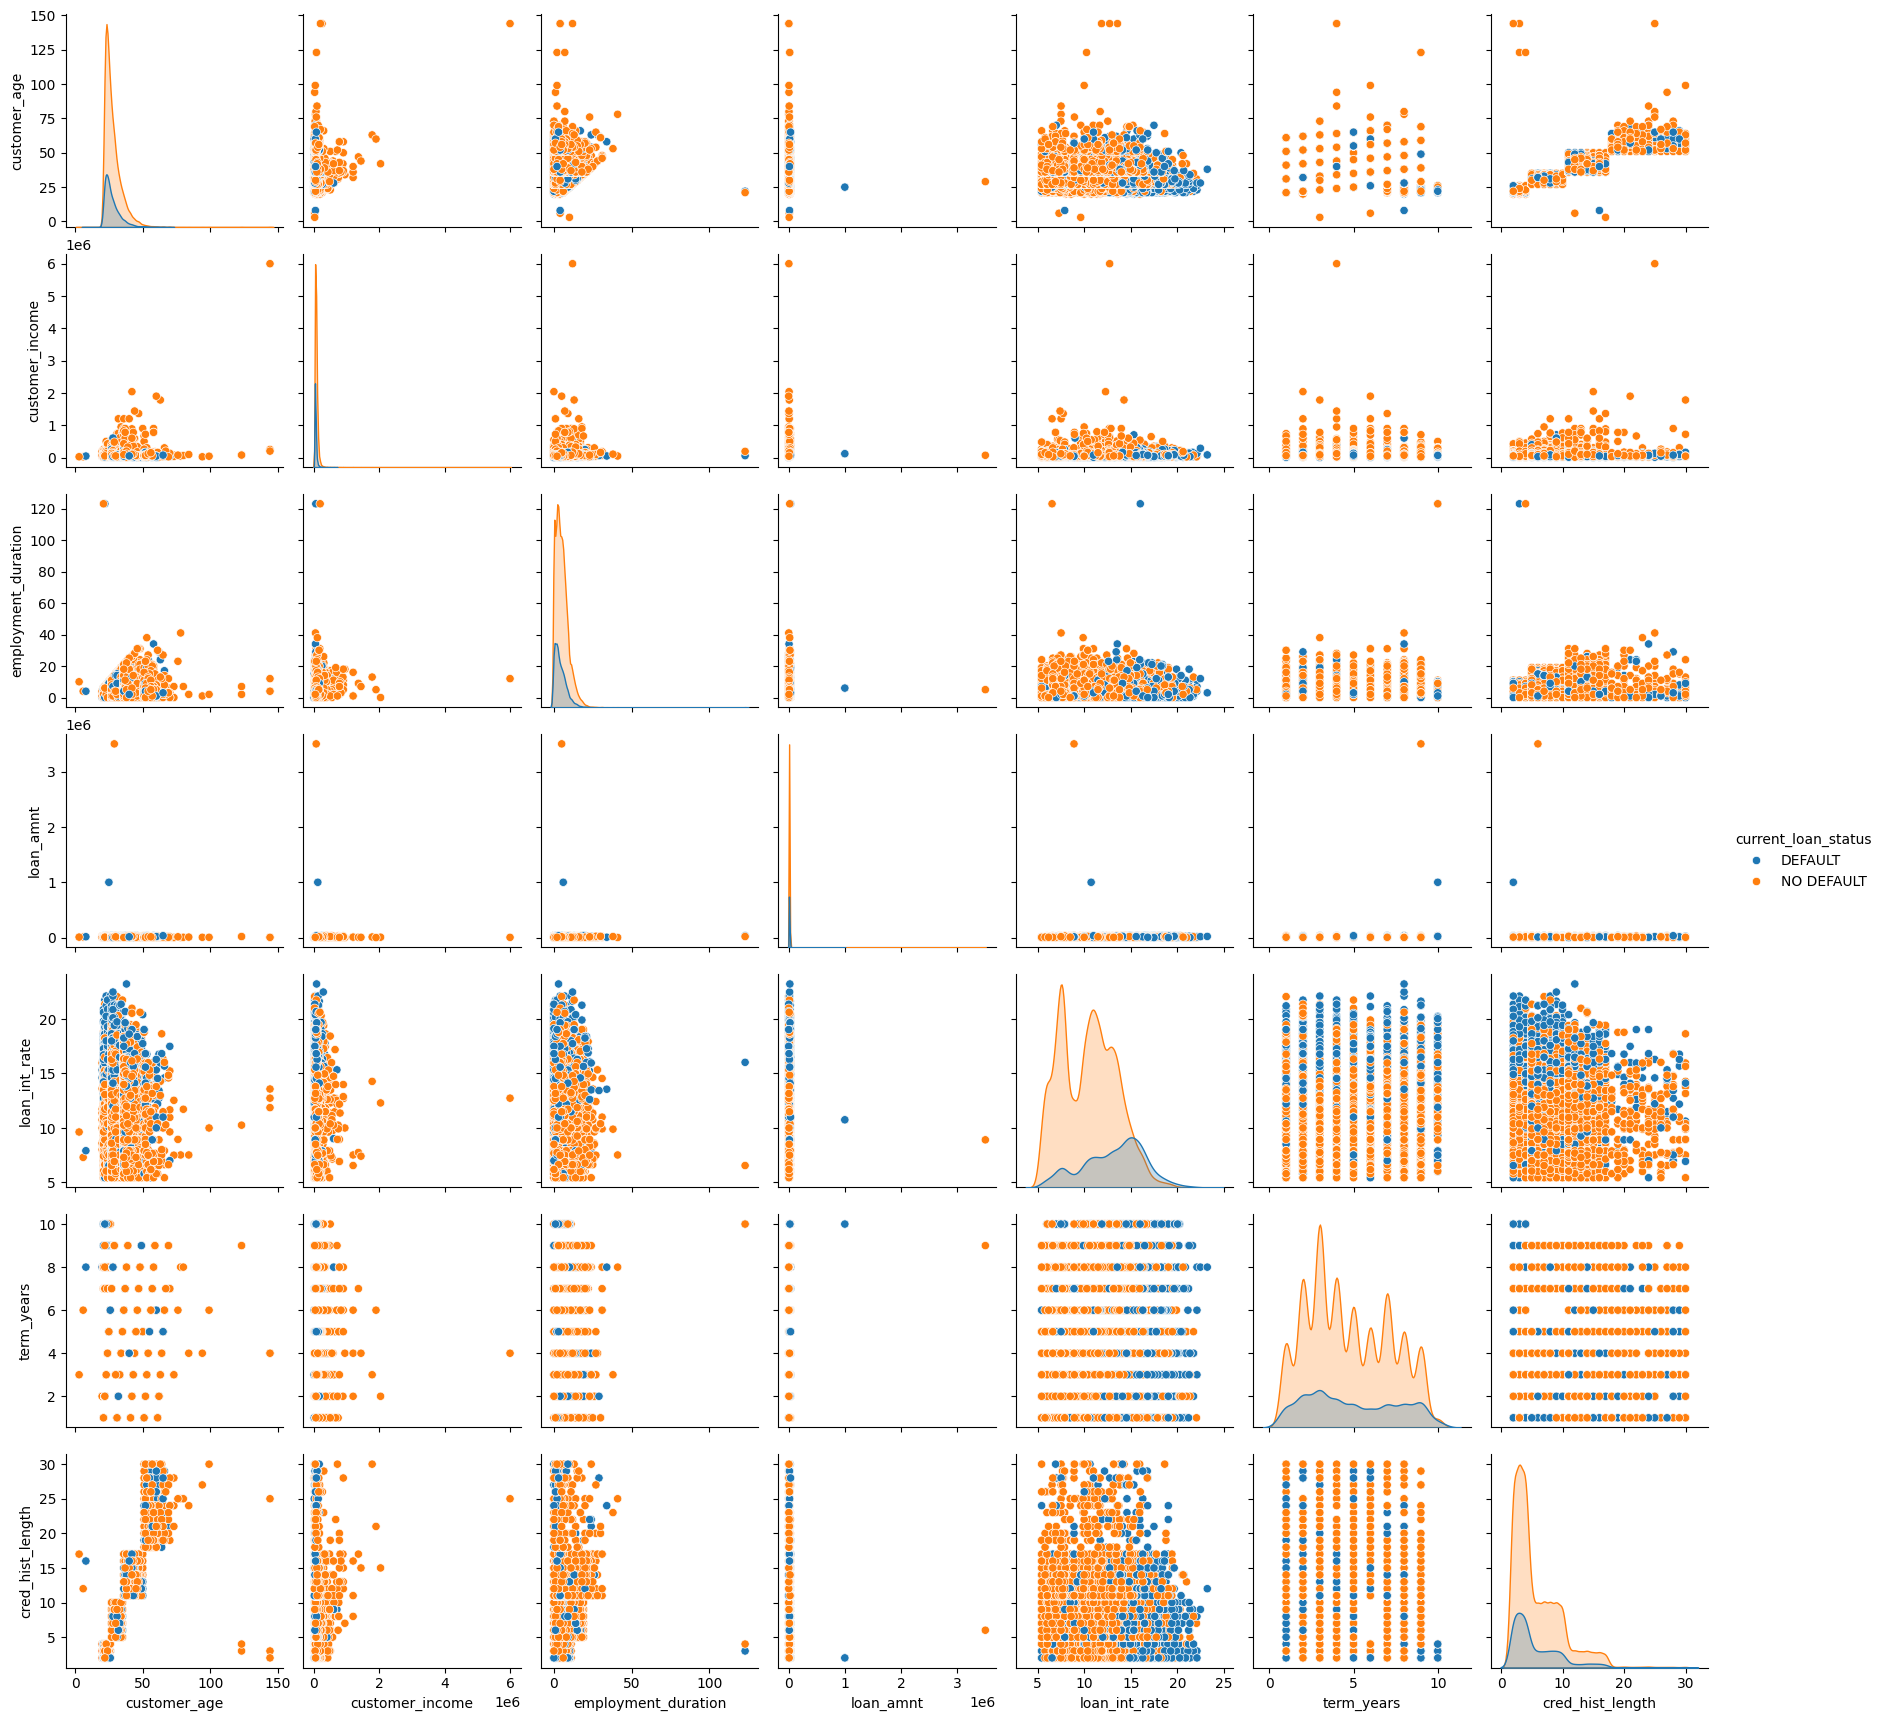

In [21]:
# I create this copy to avoid missing values in customer_income
df_copy = df.copy()
df_copy['customer_income'] = df_copy['customer_income'].str.replace(',', '').astype(float).dropna(axis=0)

numerical_columns = ['customer_age', 'customer_income', 'employment_duration', 'loan_amnt', 'loan_int_rate', 'term_years', 'cred_hist_length']
sns.pairplot(df_copy, vars=numerical_columns, hue='current_loan_status')
plt.show()

The pairplot of some columns is not visible because of outliers.

I will delete them temporally so we can have a clear distribution.

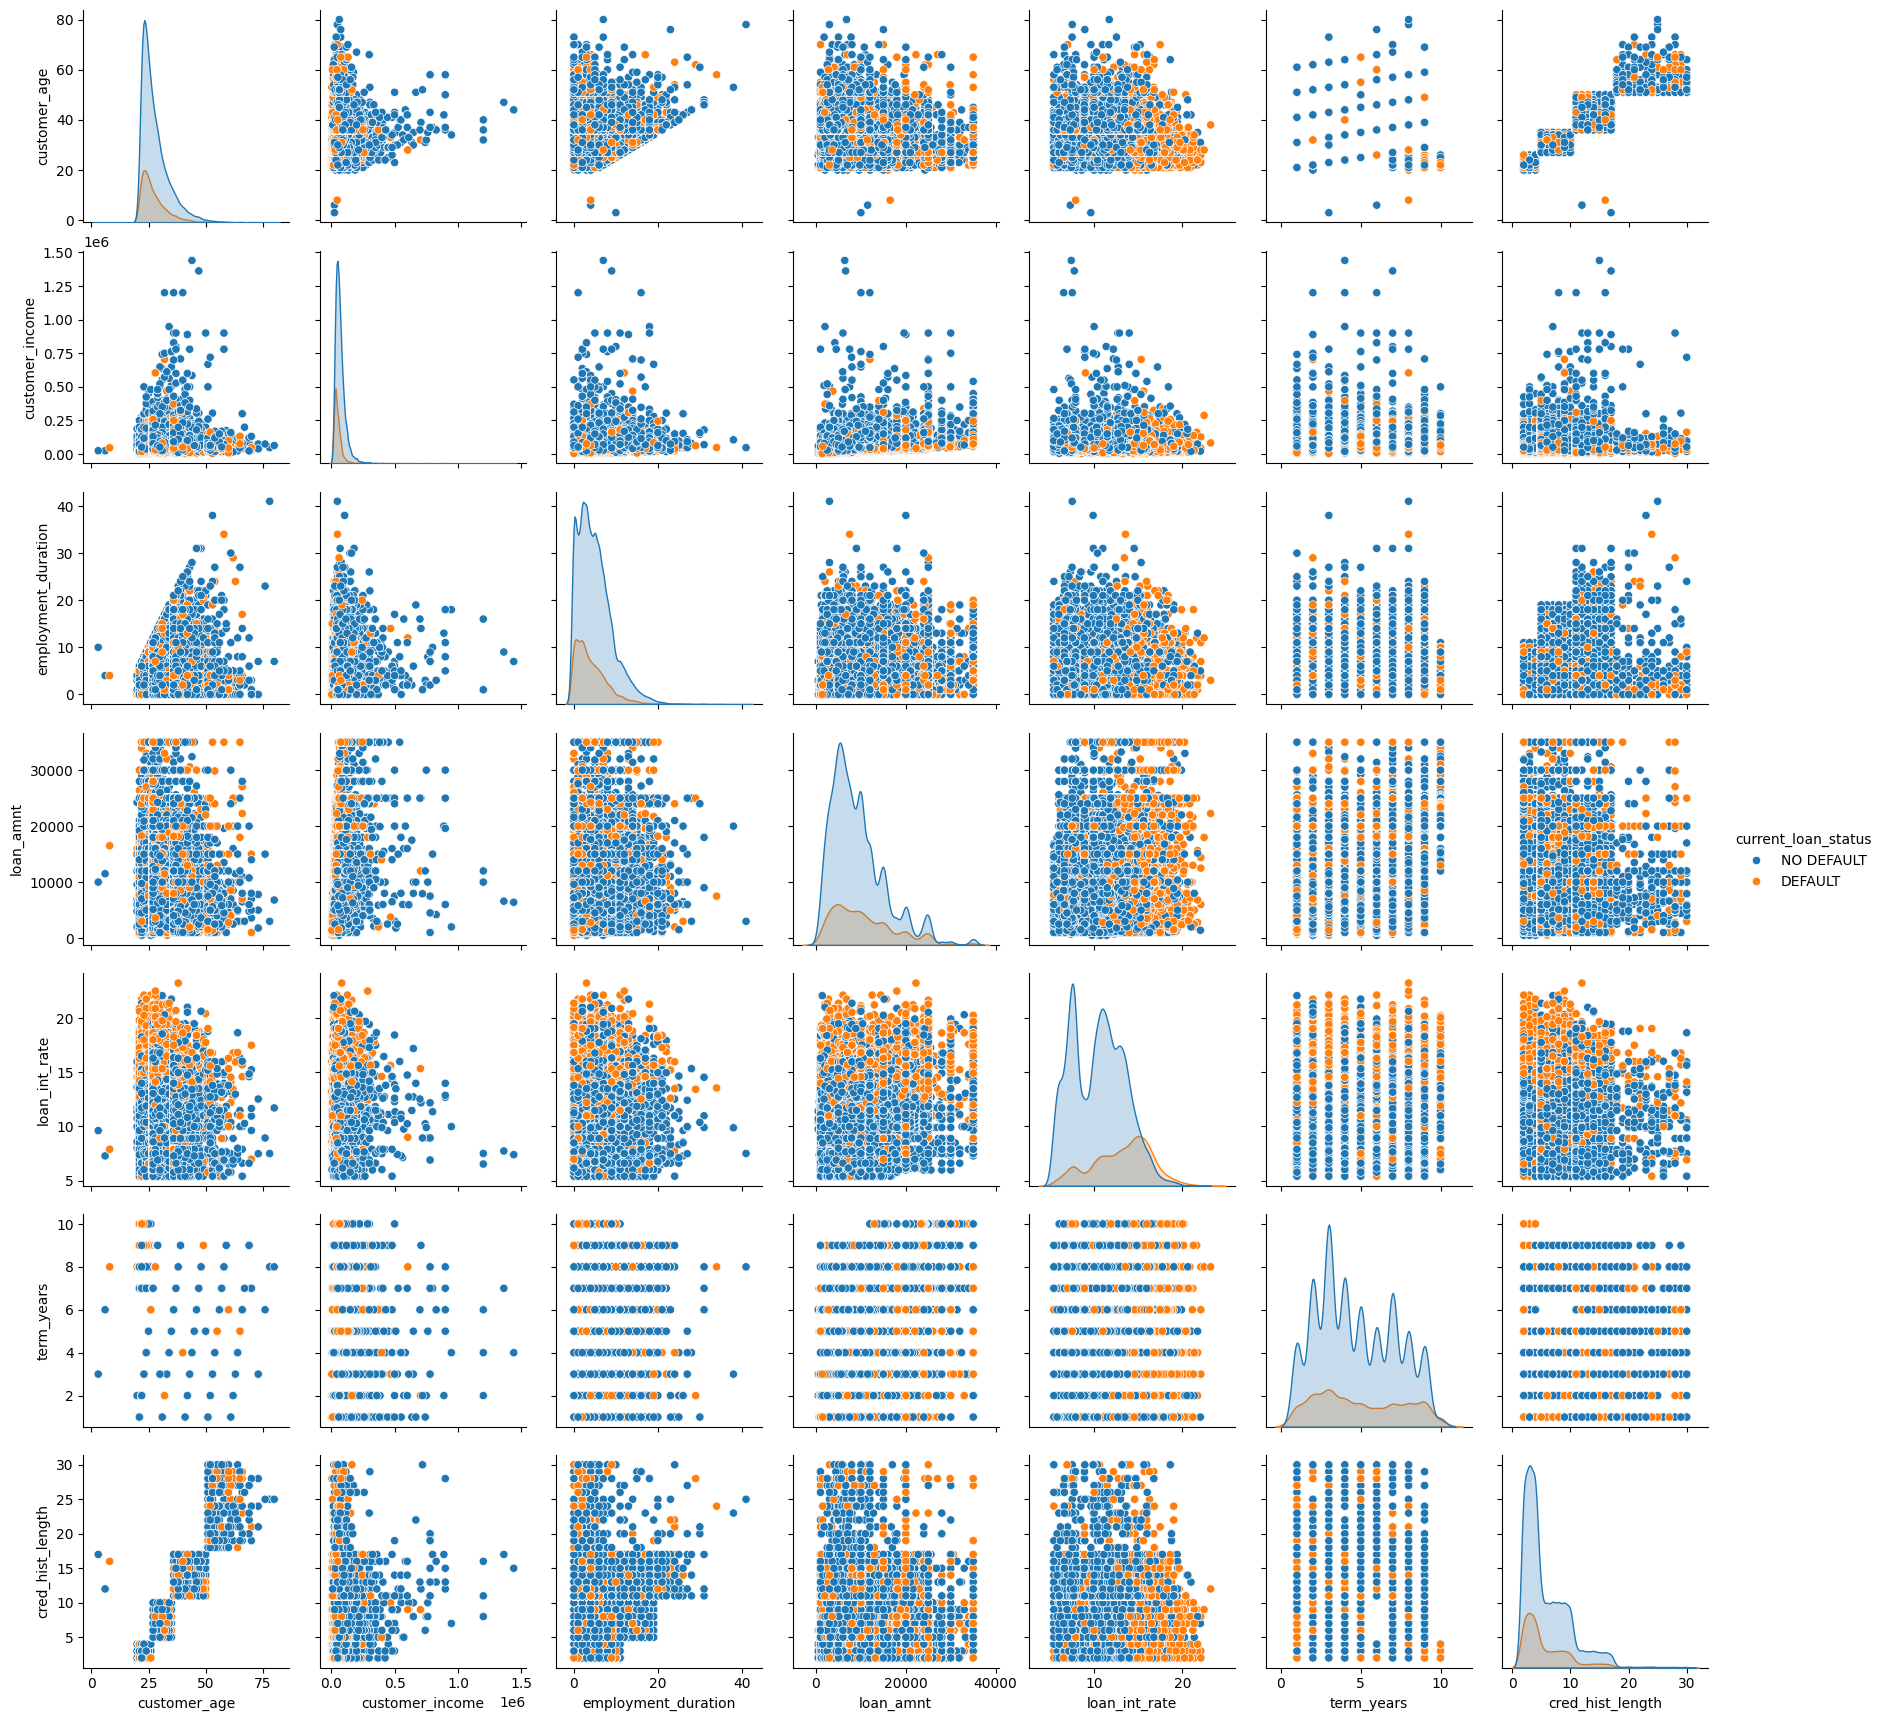

In [22]:
df_copy = df_copy.drop(df_copy['employment_duration'].sort_values(ascending=False).head(2).index, axis=0)
df_copy = df_copy.drop(df_copy['customer_income'].sort_values(ascending=False).head(4).index, axis=0)
df_copy = df_copy.drop(df_copy['loan_amnt'].sort_values(ascending=False).head(3).index, axis=0)
df_copy = df_copy.drop(df_copy['customer_age'].sort_values(ascending=False).head(7).index, axis=0)

sns.pairplot(df_copy, vars=numerical_columns, hue='current_loan_status')
plt.show()

<b>Key Insights from Loan Default Analysis</b>

**Strong Correlations**
- **Credit History Length & Age**: Strong positive relationship
- **Interest Rate & Default Risk**: Higher interest rates show increased default probability

**Default Risk Factors**
1. **Age Distribution**:
  - Default cases cluster in younger age groups (25-40)
  - More stable repayment history in 40+ age group

2. **Income Patterns**:
  - Defaults more common in lower-middle income brackets
  - High income borrowers show lower default rates
  - Some outliers in high-income defaults warrant investigation

3. **Employment Duration**:
  - Higher defaults in 0-5 years employment duration
  - Stable employment (10+ years) correlates with lower defaults

4. **Loan Terms**:
  - Short-term loans (2-5 years) show mixed default patterns
  - Long-term loans (7+ years) have more consistent repayment

5. **Credit History**:
  - Longer credit history strongly correlates with lower defaults
  - Critical threshold appears around 10 years of credit history

<b>Business Implications</b>
- Focus risk assessment on younger borrowers with shorter credit history
- Consider employment duration heavily in loan approval process
- Potential for tiered interest rates based on credit history length
- Review high-income default cases for potential fraud patterns

<b>Data Quality Notes</b>
- Some outliers in income and loan amount need validation
- Employment duration shows discrete clustering
- Interest rate distribution suggests standardized rate tiers

<a id="data-cleaning-and-preprocessing"></a>
### Data Cleaning and Preprocessing <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

**Note:** In this analysis, I will only remove the unrealistic values in my dataset like 123 years of experience, 8 years old customer, etc... I am trying to make the model realistic as much as I can.

In [23]:
df_cleaned = df.copy()

Delete customer_id column since it's useless in our analysis.

In [24]:
df_cleaned = df_cleaned.drop(columns=['customer_id'], axis=1)

customer_income column should be transformed to numerical column.

In [25]:
df_cleaned['customer_income'] = df_cleaned['customer_income'].str.replace('[^\\d.]', '', regex=True)
df_cleaned['customer_income'] = pd.to_numeric(df_cleaned['customer_income'])

Removing unrealistic ages or exceptions

In [26]:
df_cleaned = df_cleaned[(df_cleaned['customer_age'] >= 18) & (df_cleaned['customer_age'] <= 80)]

Deleting customer with 123 years of experience

In [27]:
# Find the maximum years of experience
max_experience = df_cleaned['employment_duration'].max()

# Remove rows with the maximum years of experience
df_cleaned = df_cleaned[df_cleaned['employment_duration'] != max_experience]

In [28]:
df_cleaned.isnull().sum()

customer_age               0
customer_income            0
home_ownership             0
employment_duration      895
loan_intent                0
loan_grade                 0
loan_amnt                  1
loan_int_rate           3114
term_years                 0
historical_default     20731
cred_hist_length           0
current_loan_status        4
dtype: int64

<b>Encoding/Transforming</b>

**Note:** I started with encoding instead of filling missing values because I am going to use "Iterative Imputer" and "KNN imputer" and these imputers don't accept values with types other than numerics

In [29]:
df_encoded = df_cleaned.copy()
# Perform one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=['loan_intent', 'home_ownership'], drop_first=True)

# Encode binary columns
df_encoded['current_loan_status'] = df_encoded['current_loan_status'].map({'NO DEFAULT': 0, 'DEFAULT': 1})

# Encode the ordinal column 'loan_grade'
grade_mapping = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5}
df_encoded['loan_grade'] = df_encoded['loan_grade'].map(grade_mapping)

# Convert the 'historical_default' column to numeric, mapping 'Y' to 1 and 'N' to 0
df_encoded['historical_default'] = df_encoded['historical_default'].map({'Y': 1, 'N': 0})

# Display the first few rows of the encoded dataframe
df_encoded.head()

,customer_age,customer_income,employment_duration,loan_grade,loan_amnt,loan_int_rate,term_years,historical_default,cred_hist_length,current_loan_status,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT
1,21,9600,5.0,1,1000.0,11.14,1,NaN,2,0.0,True,False,False,False,False,False,True,False
2,25,9600,1.0,2,5500.0,12.87,5,0.0,3,1.0,False,False,True,False,False,False,False,False
3,23,65500,4.0,2,35000.0,15.23,10,0.0,2,1.0,False,False,True,False,False,False,False,True
4,24,54400,8.0,2,35000.0,14.27,10,1.0,4,1.0,False,False,True,False,False,False,False,True
5,21,9900,2.0,1,2500.0,7.14,1,0.0,2,1.0,False,False,False,False,True,False,True,False


<b>Filling missing values</b>

For filling missing values, I will use MICE impute strategy since the model is a little bit complex and it doesn't show linearity between variable.

In [30]:
def is_binary_column(series):
    """
    More robust check if a column is binary
    Returns: bool, original_values
    """
    # Drop NA values and get unique values
    unique_vals = pd.Series(series.dropna().unique())

    # Convert to numeric if possible
    if unique_vals.dtype == 'object':
        try:
            unique_vals = pd.to_numeric(unique_vals)
        except:
            pass

    # Check if there are exactly 2 unique values
    is_binary = len(unique_vals) == 2

    # If binary, return the original unique values for later use
    return is_binary, sorted(unique_vals) if is_binary else None

def impute_with_mice(df, target_column='historical_default', exclude_columns=None, n_iterations=10, random_state=42):
    
    # Create a copy of the dataframe
    df_imputed = df.copy()

    # Initialize exclude_columns if None
    if exclude_columns is None:
        exclude_columns = []

    # Add target_column to exclude_columns if not already present
    if target_column not in exclude_columns:
        exclude_columns = exclude_columns + [target_column]

    # Select features for imputation (excluding target column and specified columns)
    features = [col for col in df_imputed.columns
            if col not in exclude_columns]

    # Check if target column is binary and get original values if it is
    is_binary, binary_values = is_binary_column(df[target_column])

    # Always use RandomForestRegressor for the initial imputation
    estimator = RandomForestRegressor(n_estimators=100, random_state=random_state)

    if is_binary:
        print(f"\nDetected '{target_column}' as binary column with values: {binary_values}")
    else:
        print(f"\nDetected '{target_column}' as continuous column")

    # Initialize MICE imputer
    mice_imputer = IterativeImputer(
        estimator=estimator,
        n_nearest_features=None,
        imputation_order='random',
        max_iter=n_iterations,
        random_state=random_state
    )

    # Store original missing value locations
    missing_mask = df_imputed[target_column].isna()

    # Create feature matrix for imputation
    X = df_imputed[features].copy()
    y = df_imputed[target_column].copy()

    # Convert target to numeric if possible
    if y.dtype == 'object':
        try:
            y = pd.to_numeric(y)
        except:
            raise ValueError(f"Column {target_column} cannot be converted to numeric format")

    # Create a temporary DataFrame for imputation
    temp_df = pd.concat([X, y], axis=1)

    # Perform imputation
    imputed_values = mice_imputer.fit_transform(temp_df)

    # Create DataFrame with imputed values
    df_imputed = pd.DataFrame(imputed_values, columns=temp_df.columns, index=df_imputed.index)

    # If binary, convert imputed values back to original binary values
    if is_binary:
        threshold = np.mean(binary_values)
        df_imputed[target_column] = np.where(
            df_imputed[target_column] >= threshold,
            binary_values[1],
            binary_values[0]
        )

    # Restore excluded columns
    for col in exclude_columns:
        if col != target_column:
            df_imputed[col] = df[col]

    

    return df_imputed

# Example usage
for col in ['historical_default', 'loan_int_rate', 'employment_duration']:
    df_encoded = impute_with_mice(
        df_encoded,
        target_column=col,
        exclude_columns=['current_loan_status']
    )


Detected 'historical_default' as binary column with values: [0.0, 1.0]

Detected 'loan_int_rate' as continuous column

Detected 'employment_duration' as continuous column


<b>Isolating missing "current_loan_status" rows and Creating dataframe for training</b>

In [31]:
df_missing = df_encoded[df_encoded.isnull().any(axis=1)]
df_train = df_encoded.dropna()

<a id="model-building"></a>
### Model Building <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

##### Util functions
These functions are gonna be used frequently in our analysis

In [32]:
# Function to save a model and results
def save_model(results, best_model, best_model_name, filename):
    # Create directory if it does not exist
    if not os.path.exists('models'):
        os.makedirs('models')

    # File path
    filepath = os.path.join('models', f"{filename}.pkl")

    # Save all information
    with open(filepath, 'wb') as file:
        pickle.dump((results, best_model, best_model_name), file)

    print(f"All information saved to {filepath}")


# Function to load a model
def load_model(filename):
    # File path
    filepath = os.path.join('models', f"{filename}.pkl")
    # Load all information
    with open(filepath, 'rb') as file:
        results, best_model, best_model_name = pickle.load(file)

    print(f"All information loaded from {filepath}")

    return results, best_model, best_model_name

In [33]:
# Initialize an empty DataFrame to store model names and metrics
model_metrics_df = pd.DataFrame(columns=['Model Name', 'Fold', 'Accuracy', 'Precision', 'Recall', 'AUC', 'F1'])

In [34]:
def display_features_importance(model, model_name, X, y):
    # Create a DataFrame with feature importances for the GBM model
    importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    })

    # Sort the features by importance for GBM
    importances = importances.sort_values(by='Importance', ascending=False)

    # Plot the feature importances for GBM
    plt.figure(figsize=(12, 8))
    barplot = sns.barplot(x='Importance', y='Feature', data=importances)
    plt.title('Feature Importances - {}'.format(model_name))
    plt.xlabel('Importance')
    plt.ylabel('Feature')

    # Add value labels to the bars
    for index, value in enumerate(importances['Importance']):
        barplot.text(value, index, round(value, 4), color='black', ha="left")

    plt.show()

In [35]:
def display_store_metrics(model, model_name, X, y):
    global model_metrics_df
    global results_metrics
    # Predict on the training set
    y_pred = model.predict(X)

    # Print classification report
    print(classification_report(y, y_pred))

    # Display the confusion matrix for the current fold
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NO DEFAULT', 'DEFAULT'], yticklabels=['NO DEFAULT', 'DEFAULT'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Calculate precision, recall, f1 score, and ROC AUC score
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred)
    # Create a dictionary with the model's metrics
    model_metrics = {
        'Model Name': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUC': roc_auc,
        'F1': f1
    }

    # Print the scores
    print("Accuracy: ", accuracy)
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1: {f1:.4f}")
    print(f"AUC: {roc_auc:.4f}")

    # Append the dictionary as a new row to the DataFrame
    if model_metrics_df.empty:
        model_metrics_df = pd.DataFrame([model_metrics])
    else:
        model_metrics_df = pd.concat([model_metrics_df, pd.DataFrame([model_metrics])], ignore_index=True)

    print(model_metrics_df.head(len(model_metrics_df)).sort_values(by='F1', ascending=False))

**<u>Note :</u>**

The following cell is where I build my models. In this analysis, I decided to use only XGBoost and LightGBM since they generally perform the best in classification models and I will focus on finding the best f1-score.

Since we are building a model for loan default, I decided to use the threshold by setting the value low (in my case, I used 0.3) because it will increase the recall hence reducing false negatives. Which means, the model is more likely to detect more defaulters but risks more false positives (people who actually can pay the loan).

This model is optimal when the economy is bad since defaulting a loan can lead to big losses, especially when the number of loans is low.

In [ ]:
# Disable all logs globally
logging.disable(logging.CRITICAL)
xgb.set_config(verbosity=0)
optuna.logging.set_verbosity(optuna.logging.ERROR)

def find_optimal_threshold(model, X_val, y_val, recall_weight=0.5):
  y_proba = model.predict_proba(X_val)[:, 1]
  thresholds = np.linspace(0.1, 0.4, 100)  # Test thresholds between 0.1 and 0.9
  best_cost = float('inf')
  optimal_threshold = 0.3

  for thresh in thresholds:
      y_pred = (y_proba >= thresh).astype(int)
      tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

      # Cost function: Minimize false positives while maintaining recall
      cost = fp - recall_weight * tp  # Adjust recall_weight to prioritize recall
      if cost < best_cost:
          best_cost = cost
          optimal_threshold = thresh

  return optimal_threshold

class AdvancedBoostingOptimization:
  def __init__(self, X, y, k=5, max_time_mins=60, balance=False, fe=''):
      self.fe = fe
      self.X = X
      self.y = y
      self.k = k
      self.max_time_mins = max_time_mins
      self.balance = balance  # Whether to balance the dataset
      self.start_time = None

      # Create validation set for early stopping
      self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
          X, y, test_size=0.2, random_state=42, stratify=y
      )

      # Balance the training set if required
      if self.balance:
          smote = SMOTE(random_state=42)
          self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)

      # Initialize cross-validation
      self.cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

      # Calculate scale_pos_weight dynamically
      pos_weight = np.sum(self.y == 0) / np.sum(self.y == 1)

      # Optimized parameter ranges for each model
      self.param_ranges = {
          'XGBoost': {
              'learning_rate': (0.01, 0.3),
              'max_depth': (3, 10),
              'min_child_weight': (1, 7),
              'subsample': (0.5, 1.0),
              'colsample_bytree': (0.5, 1.0),
              'gamma': (0, 5),
              'n_estimators': (50, 500),
              'max_delta_step': (0, 10),
              'scale_pos_weight': (pos_weight - 1, pos_weight + 1)  # Dynamic scaling
          },
          'LightGBM': {
              'learning_rate': (0.01, 0.1),  # Reduced upper bound for more stable learning
                'num_leaves': (20, 100),  # Reduced upper bound to prevent overfitting
                'max_depth': (3, 8),  # Reduced upper bound for more balanced trees
                'min_child_samples': (20, 100),  # Increased lower bound to ensure sufficient samples
                'subsample': (0.7, 1.0),  # Increased lower bound for more stable splits
                'colsample_bytree': (0.7, 1.0),  # Increased lower bound for feature stability
                'n_estimators': (100, 500),  # Adjusted range for better convergence
                'min_split_gain': (0.1, 0.5),  # Added minimum threshold to prevent unstable splits
                'scale_pos_weight': (pos_weight - 0.5, pos_weight + 0.5)  # Narrowed range for class weight
          },
          'CatBoost': {
              'learning_rate': (0.01, 0.3),
              'depth': (4, 10),
              'l2_leaf_reg': (1.0, 10.0),
              'iterations': (50, 500),
              'min_child_samples': (10, 100),
              'bootstrap_type': 'Bernoulli',
              'random_strength': (0, 10),
              'border_count': (32, 255),
              'scale_pos_weight': (pos_weight - 1, pos_weight + 1)  # Dynamic scaling
          }
      }

      # Early stopping configurations
      self.early_stopping_rounds = 20

  def _time_exceeded(self):
      """Check if we've exceeded our time budget"""
      if self.start_time is None:
          return False
      elapsed_mins = (time.time() - self.start_time) / 60
      return elapsed_mins > self.max_time_mins

  def create_model(self, model_name, params):
      """Create a model with early stopping"""
      base_params = {
          'XGBoost': {
              'tree_method': 'hist',  # Use CPU-based histogram method
              'device': 'cpu',        # Use CPU
              'random_state': 42,
              'early_stopping_rounds': self.early_stopping_rounds,
              'verbose': 0,          # Suppress logs
              'silent': True,
              'verbosity': 0
          },
          'LightGBM': {
              'device': 'cpu',        # Use CPU
              'random_state': 42,
              'early_stopping_rounds': self.early_stopping_rounds,
              'silent': True,
              'verbose': -1
          },
          'CatBoost': {
              'task_type': 'CPU',     # Use CPU
              'random_state': 42,
              'early_stopping_rounds': self.early_stopping_rounds,
              'silent': True          # Suppress logs
          }
      }

      if model_name == 'XGBoost':
          base_params['XGBoost'].update(params)
          return xgb.XGBClassifier(**base_params['XGBoost'])
      elif model_name == 'LightGBM':
          base_params['LightGBM'].update(params)
          return lgb.LGBMClassifier(**base_params['LightGBM'])
      elif model_name == 'CatBoost':
          base_params['CatBoost'].update(params)
          return cb.CatBoostClassifier(**base_params['CatBoost'])

  def objective(self, trial, model_name):
    """Optuna objective function with optimal threshold tuning"""
    if self._time_exceeded():
        raise optuna.exceptions.TrialPruned()

    params = {}
    for param, range_values in self.param_ranges[model_name].items():
        if isinstance(range_values[0], int):
            params[param] = trial.suggest_int(param, range_values[0], range_values[1])
        elif isinstance(range_values[0], float):
            params[param] = trial.suggest_float(param, range_values[0], range_values[1])

    model = self.create_model(model_name, params)

    # Use cross-validation with early stopping
    scores = []
    for train_idx, val_idx in self.cv.split(self.X_train, self.y_train):
        X_fold_train, X_fold_val = self.X_train[train_idx], self.X_train[val_idx]
        y_fold_train, y_fold_val = self.y_train[train_idx], self.y_train[val_idx]

        if model_name == 'CatBoost':
            train_pool = cb.Pool(X_fold_train, y_fold_train)
            eval_pool = cb.Pool(X_fold_val, y_fold_val)
            model.fit(train_pool, eval_set=eval_pool)
        elif model_name == 'LightGBM':
            model.fit(
                X_fold_train, y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                callbacks=[log_evaluation(period=-1)]
            )
        else:
            model.fit(
                X_fold_train, y_fold_train,
                eval_set=[(X_fold_val, y_fold_val)],
                verbose=False
            )

        # Get predicted probabilities
        y_proba = model.predict_proba(X_fold_val)[:, 1]

        # Find optimal threshold for this fold
        optimal_threshold = find_optimal_threshold(model, X_fold_val, y_fold_val)

        # Adjust predictions using the optimal threshold
        y_pred = (y_proba >= optimal_threshold).astype(int)

        # Use F1-score as the optimization metric
        scores.append(f1_score(y_fold_val, y_pred))

    return np.mean(scores)

  def run_optimization(self):
    """Run optimization with optimal threshold tuning"""
    self.start_time = time.time()
    results = []
    models_tab = pd.DataFrame()
    best_estimators = {}

    # for model_name in ['LightGBM', 'XGBoost']:
    for model_name in ['XGBoost', 'LightGBM']:
        if self._time_exceeded():
            print(f"Time budget exceeded, skipping {model_name}")
            continue

        print(f"\nOptimizing {model_name}...")

        try:
            # Optuna optimization with time budget
            study = optuna.create_study(direction='maximize', sampler=TPESampler(), pruner=MedianPruner())
            study.optimize(
                partial(self.objective, model_name=model_name),
                show_progress_bar=False,
                n_trials=200,
                n_jobs = -1,
                timeout=self.max_time_mins * 60 / 2  # Divide time budget among models
            )

            # Train final model with best parameters
            best_params = study.best_params.copy()
            best_model = self.create_model(model_name, best_params)

            if model_name == 'CatBoost':
                train_pool = cb.Pool(self.X_train, self.y_train)
                eval_pool = cb.Pool(self.X_val, self.y_val)
                best_model.fit(train_pool, eval_set=eval_pool)
            elif model_name == 'LightGBM':
                best_model.fit(
                    self.X_train, self.y_train,
                    eval_set=[(self.X_val, self.y_val)],
                    callbacks=[log_evaluation(period=-1)]
                )
            else:
                best_model.fit(
                    self.X_train, self.y_train,
                    eval_set=[(self.X_val, self.y_val)],
                    verbose=False
                )

            # Get predicted probabilities
            y_proba = best_model.predict_proba(self.X_val)[:, 1]

            # Find optimal threshold for the validation set
            optimal_threshold = find_optimal_threshold(best_model, self.X_val, self.y_val)

            # Adjust predictions using the optimal threshold
            y_pred = (y_proba >= optimal_threshold).astype(int)

            # Evaluate on validation set
            tn, fp, fn, tp = confusion_matrix(self.y_val, y_pred).ravel()
            results.append({
                'model': model_name + self.fe,
                'f1_score': f1_score(self.y_val, y_pred),
                'accuracy': accuracy_score(self.y_val, y_pred),
                'precision': precision_score(self.y_val, y_pred),
                'recall': recall_score(self.y_val, y_pred),
                'roc_auc': roc_auc_score(self.y_val, y_proba),
                'true_negatives': tn,
                'false_positives': fp,
                'best_params': best_params,
                'best_threshold': optimal_threshold,
                'n_trials': len(study.trials)
            })
            

            new_row = pd.DataFrame({
                'name': [model_name + self.fe],
                'f1_score': [f1_score(self.y_val, y_pred)],
                'model': [best_model]
            })
            models_tab = pd.concat([models_tab, new_row], ignore_index=True)

            best_estimators[model_name + self.fe] = best_model
            save_model(results, best_model, model_name + self.fe, model_name + self.fe)
            display_store_metrics(best_model, results, self.X, self.y)

        except Exception as e:
            print(f"Error optimizing {model_name + self.fe}: {str(e)}")
            continue

    results_df = pd.DataFrame(results)
    best_model_name = results_df.loc[results_df['f1_score'].idxmax(), 'model']
    best_model_idx = models_tab['f1_score'].idxmax()
    best_model = models_tab.loc[best_model_idx, 'model']
    
    save_model(results_df, best_model, best_model_name, 'best_model' + self.fe)

    return results_df, best_model, best_model_name

<b>Train/Test split</b>

In [37]:
df_train.isna().sum()

customer_age                   0
customer_income                0
loan_grade                     0
loan_amnt                      0
term_years                     0
cred_hist_length               0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL           0
loan_intent_VENTURE            0
home_ownership_OTHER           0
home_ownership_OWN             0
home_ownership_RENT            0
historical_default             0
loan_int_rate                  0
employment_duration            0
current_loan_status            0
dtype: int64

Since we are dealing with a medium dataset and imbalanced target variable, it's better to use stratified K fold validation

In [38]:
y = df_train['current_loan_status']
X = df_train.drop(columns=['current_loan_status'], axis=1)

# Define the Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {}
param_grids = {}

<b>Training Machine Learning Models</b>

In [39]:
optuna.logging.set_verbosity(optuna.logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message=".*'force_all_finite'.*")
warnings.filterwarnings('ignore', message='.*ensure_all_finite.*')

# import warnings
# warnings.filterwarnings('ignore')
# optuna.logging.set_verbosity(optuna.logging.ERROR)

# Usage example
def optimize_boosting(X, y, max_time_mins=60, fe=''):
    # Convert data to numpy arrays if needed
    X = X.to_numpy()
    y = y.to_numpy()
    optimizer = AdvancedBoostingOptimization(X, y, max_time_mins=max_time_mins, balance=True, fe=fe)
    return optimizer.run_optimization()


# Run the function
model_filepath = 'models/best_model.pkl'
if not os.path.exists(model_filepath):
    results_df, best_model, best_model_name = optimize_boosting(X, y, max_time_mins=60)
else:
    results_df, best_model, best_model_name = load_model('best_model')

# Print results
print("\nBest model:", best_model_name)
print("\nDetailed results:")
print(results_df)

All information loaded from models\best_model.pkl

Best model: XGBoost

Detailed results:
      model  f1_score  accuracy  precision    recall   roc_auc  \
0   XGBoost  0.838306  0.932607   0.844840  0.831871  0.958419   
1  LightGBM  0.826369  0.926006   0.814631  0.838450  0.954587   

   true_negatives  false_positives  \
0            4937              209   
1            4885              261   

                                         best_params  best_threshold  n_trials  
0  {'learning_rate': 0.09119944786963806, 'max_de...             0.4       200  
1  {'learning_rate': 0.09257757252341554, 'num_le...             0.4       200  


<a id="model-evaluation"></a>
### Model Evaluation <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

<b>Display metrics</b>

In [40]:
display(results_df.sort_values(by='f1_score').head())

,model,f1_score,accuracy,precision,recall,roc_auc,true_negatives,false_positives,best_params,best_threshold,n_trials
1,LightGBM,0.826369,0.926006,0.814631,0.838450,0.954587,4885,261,"{'learning_rate': 0.09257757252341554, 'num_le...",0.4,200
0,XGBoost,0.838306,0.932607,0.844840,0.831871,0.958419,4937,209,"{'learning_rate': 0.09119944786963806, 'max_de...",0.4,200


The best model found is XGBoost.

<b>Display Matrix confusion</b>

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     25731
         1.0       0.97      0.96      0.97      6838

    accuracy                           0.99     32569
   macro avg       0.98      0.98      0.98     32569
weighted avg       0.99      0.99      0.99     32569



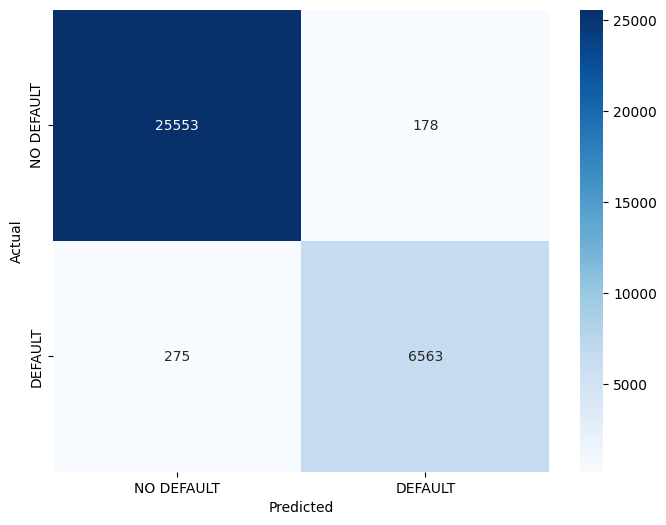

Accuracy:  0.9860910681936811
Precision: 0.9736
Recall: 0.9598
F1: 0.9666
AUC: 0.9764
                                          Model Name  Accuracy  Precision  \
0                                                ...  0.986091   0.973594   

     Recall       AUC       F1  
0  0.959784  0.976433  0.96664  


In [41]:
display_store_metrics(best_model, results_df.T, X, y)

**Key insights**
- Strong overall performance – Correctly classified 25,553 non-defaulters and 6,563 defaulters.
- Low False Positives (Type I Error) – Only 178 non-defaulters were misclassified as defaulters (~0.7%).
- Moderate False Negatives (Type II Error) – 275 defaulters were misclassified as non-defaulters (~4%).
- High Recall for Defaulters – 95.98% (6,563/6,838), meaning most defaulters are correctly identified.
- High Specificity for Non-Defaulters – 99.3% (25,553/25,731), minimizing wrongful loan rejections.

<b>Display Feature Importance</b>

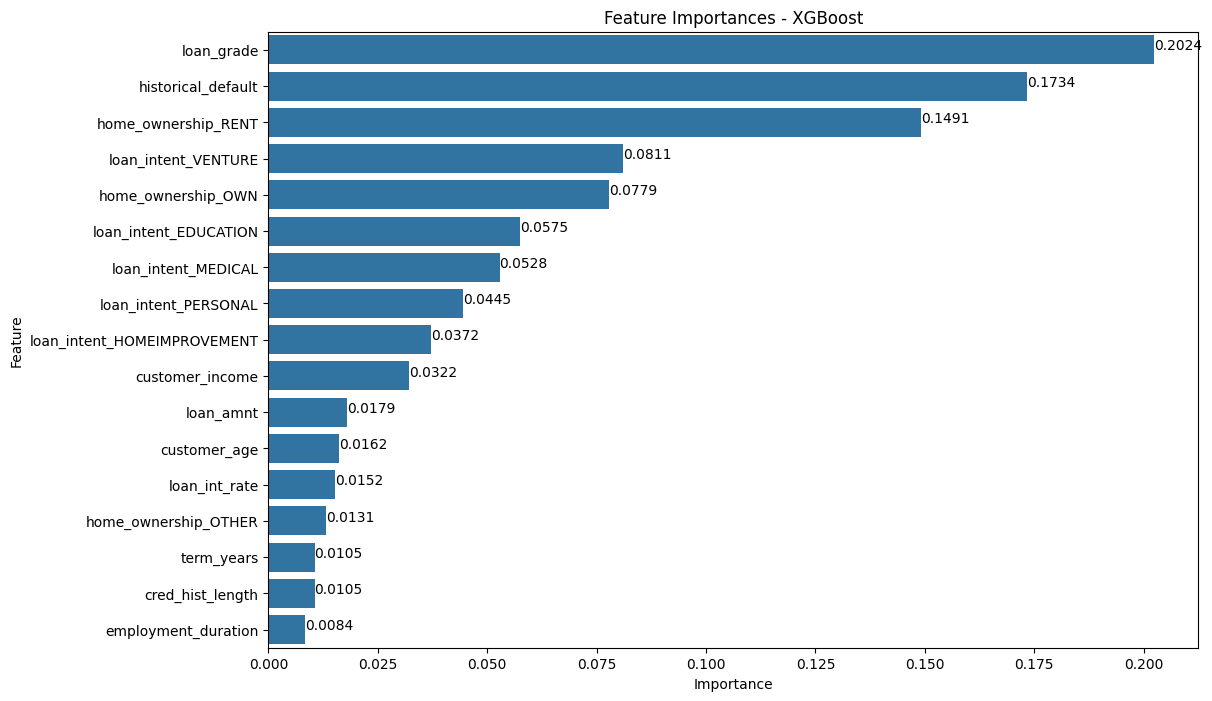

In [42]:
display_features_importance(best_model, best_model_name, X, y)

This model is putting mor emphasis on the loan grade and historical default history.

Like we saw in the EDA, home ownership can be a good predictor for people who are more likely to default their loan. People who own home are very like to pay their debts and people who rent are very likely to **not** pay their loan.

The same thing can be said on loan intent. `Venture` and `Education` are the less likely to default their loans.

**POV :** I find it strange the model didn't rank customer income and loan interest rate high. Maybe it's because it is integrated in loan grade.

<b>Predicting loan status for rows with missing target</b>

In [43]:
# Assuming df_missing is your DataFrame with missing Current_loan_status
# and X is the DataFrame used for training the models

# Preprocess df_missing in the same way as your training data
df_missing_copy = df_missing.copy()
# Ensure df_missing has the same structure as your training DataFrame X
X_missing = df_missing_copy.drop('current_loan_status', axis=1)

# Predict using the trained Random Forest model
df_missing_copy['current_loan_status_predicted'] = best_model.predict(X_missing)

# Optional: If you want to combine predictions from both models, you can use a simple majority vote or other ensemble methods
# df_missing_copy['current_loan_status_final'] = (df_missing_copy[['current_loan_status_predicted_gbm', 'current_loan_status_predicted_rf']].mean(axis=1) > 0.5).astype(int)

# Map encoded predictions back to original labels (0 -> 'NO DEFAULT', 1 -> 'DEFAULT')
df_missing_copy['current_loan_status_predicted'] = df_missing_copy['current_loan_status_predicted'].map({0: 'NO DEFAULT', 1: 'DEFAULT'})

# Display the DataFrame with predictions
print(df_missing_copy['current_loan_status_predicted'].head().T)

21791    NO DEFAULT
22076       DEFAULT
22742    NO DEFAULT
23069    NO DEFAULT
Name: current_loan_status_predicted, dtype: object


<a id="#feature-engineering"></a>
### Feature Engineering <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [44]:
df_encoded_v2 = df_encoded.copy()

**Feature Engineering Function Summary**

 1. <b>Missing Value & Low Importance Feature Handling**</b>
- Manages rare categories (e.g., 'home_ownership_OTHER')
- Combines loan grades D and E into D+
- Imputes missing values in customer_income with median

 2. Binning Numeric Features
- Employment Duration: Categorized into '0-2', '2-5', '5-10', '10+' years
- Customer Age: Grouped into '<30', '30-40', '40-50', '50+' years

 3. Interaction Features
Creates compound features:
- Income × Employment Duration
- Age × Credit History Length

 4. Financial Ratios & Metrics
Creates financial indicators:
- Income to Loan Ratio
- Total Interest Amount
- Income Stability Score
- Age to Employment Ratio
- Credit History to Loan Ratio
- Total Interest Over Term
- Debt-to-Income Ratio
- Loan-to-Income Ratio
- Credit Utilization Rate

 5. Categorical Encoding
- One-hot encodes the new binned features
- Preserves categorical information while making it model-ready

 6. Cleanup
- Removes original features that were transformed
- Drops redundant columns

**Purpose:** This function transforms raw loan data into richer, more informative features while maintaining data integrity and reducing noise. It focuses on creating meaningful financial ratios and demographic groupings that are likely to be predictive of loan default risk.

In [45]:
def feature_engineering(df):
    
    # --- 1. Handle Missing or Low-Importance Features ---
    # Drop columns with very low importance or high missing values (if any)
    # For example, if 'home_ownership_OTHER' is rare, we can drop it or combine it with other categories.
    if 'home_ownership_OTHER' in df.columns:
        df['home_ownership_OTHER'] = df['home_ownership_OTHER'].replace({1: 0})  # Combine with 'RENT' or drop
        # Alternatively, drop the column if it's not useful:
        # df.drop(columns=['home_ownership_OTHER'], inplace=True)
    
    # Combine loan grade D and E in D+
    df['loan_grade'] = df['loan_grade'].replace({5: 4})
    
    # Impute missing values for important features (if any)
    # For example, impute missing 'customer_income' with the median
    if df['customer_income'].isnull().any():
        df['customer_income'].fillna(df['customer_income'].median(), inplace=True)    
    
    # --- 3. Engineer Moderately Important Features ---
    # Create bins for 'employment_duration'
    df['employment_duration_bins'] = pd.cut(
        df['employment_duration'],
        bins=[0, 2, 5, 10, df['employment_duration'].max() + 1],
        labels=['0-2', '2-5', '5-10', '10+']
    )
    
    # Create bins for 'customer_age'
    df['customer_age_bins'] = pd.cut(
        df['customer_age'],
        bins=[0, 30, 40, 50, df['customer_age'].max() + 1],
        labels=['<30', '30-40', '40-50', '50+']
    )
    
    # Create interaction features for moderately important features
    df['income_employment_interaction'] = df['customer_income'] * df['employment_duration']
    df['age_credit_hist_interaction'] = df['customer_age'] * df['cred_hist_length']
    
    # --- 4. Create New Features Based on High-Importance Features ---
    # For income_to_loan_ratio
    df['income_to_loan_ratio'] = np.where(df['loan_amnt'] != 0, df['customer_income'] / df['loan_amnt'], 0)

    # For age_employment_ratio
    df['age_employment_ratio'] = np.where(df['employment_duration'] != 0, df['customer_age'] / df['employment_duration'], 0)

    # For credit_loan_ratio
    df['credit_loan_ratio'] = np.where(df['loan_amnt'] != 0, df['cred_hist_length'] / df['loan_amnt'], 0)

    # For debt_to_income_ratio and loan_to_income_ratio
    df['debt_to_income_ratio'] = np.where(df['customer_income'] != 0, df['loan_amnt'] / df['customer_income'], 0)
    df['loan_to_income_ratio'] = np.where(df['customer_income'] != 0, df['loan_amnt'] / df['customer_income'], 0)

    # For credit_utilization
    df['credit_utilization'] = np.where((df['loan_amnt'] + df['customer_income']) != 0, 
                                    df['loan_amnt'] / (df['loan_amnt'] + df['customer_income']), 0)
    
    # --- 5. Encode Categorical Features ---
    # One-hot encode categorical features
    df = pd.get_dummies(
        df,
        columns=[
            'employment_duration_bins', 'customer_age_bins'
        ],
        drop_first=True
    )
    
    # --- 6. Drop Unnecessary Columns ---
    # Drop original columns that have been binned or encoded
    df.drop(columns=['employment_duration', 'customer_age', 'loan_intent_loan_amnt'], inplace=True, errors='ignore')
    
    return df


In [46]:
# Apply feature engineering
df_encoded_v2 = feature_engineering(df_encoded_v2)

<a id="model-building-after-fe"></a>
### Model Building After Feature Engineering <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

In [47]:
# Train/Test Split
df_missing_2 = df_encoded_v2[df_encoded_v2.isnull().any(axis=1)]
df_train_2 = df_encoded_v2.dropna()

# Prepare the data
y_new = df_train_2['current_loan_status']
X_new = df_train_2.drop(columns=['current_loan_status'], axis=1)

In [48]:
# Run the function
model_filepath = 'models/best_model_FE.pkl'
if not os.path.exists(model_filepath):
    results_df_FE, best_model_FE, best_model_name_FE = optimize_boosting(X_new, y_new, max_time_mins=60, fe='_FE')
else:
    results_df_FE, best_model_FE, best_model_name_FE = load_model('best_model_FE')

# Print results
print("\nBest model:", best_model_name)
print("\nDetailed results:")
print(results_df_FE)

All information loaded from models\best_model_FE.pkl

Best model: XGBoost

Detailed results:
         model  f1_score  accuracy  precision    recall   roc_auc  \
0   XGBoost_FE  0.848393  0.938440   0.878622  0.820175  0.953780   
1  LightGBM_FE  0.834011  0.931072   0.843680  0.824561  0.953074   

   true_negatives  false_positives  \
0            4991              155   
1            4937              209   

                                         best_params  best_threshold  n_trials  
0  {'learning_rate': 0.10277252185791864, 'max_de...             0.4       200  
1  {'learning_rate': 0.07813132952042817, 'num_le...             0.4       200  


<a id="model-evaluation-after-fe"></a>
### Model Evaluation After Feature Engineering <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

<b>Display Metrics and Feature Importance</b>

In [49]:
results_df_FE

,model,f1_score,accuracy,precision,recall,roc_auc,true_negatives,false_positives,best_params,best_threshold,n_trials
0,XGBoost_FE,0.848393,0.938440,0.878622,0.820175,0.953780,4991,155,"{'learning_rate': 0.10277252185791864, 'max_de...",0.4,200
1,LightGBM_FE,0.834011,0.931072,0.843680,0.824561,0.953074,4937,209,"{'learning_rate': 0.07813132952042817, 'num_le...",0.4,200


XGBoost_FE performs slightly better than LightGBM_FE in terms of F1 score, accuracy, and precision, while LightGBM_FE has a marginally higher recall. Both models exhibit excellent ROC AUC scores, indicating strong overall performance. The optimal parameters and the best threshold provide insights into the tuning process that led to these results.

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     25731
         1.0       0.98      0.96      0.97      6838

    accuracy                           0.99     32569
   macro avg       0.98      0.98      0.98     32569
weighted avg       0.99      0.99      0.99     32569



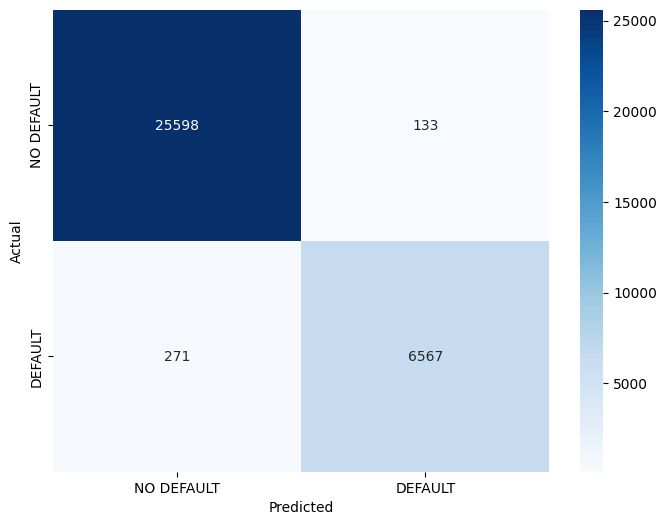

Accuracy:  0.9875955663360865
Precision: 0.9801
Recall: 0.9604
F1: 0.9702
AUC: 0.9776
                                          Model Name  Accuracy  Precision  \
1           model  f1_score  accuracy  precision ...  0.987596   0.980149   
0                                                ...  0.986091   0.973594   

     Recall       AUC        F1  
1  0.960369  0.977600  0.970158  
0  0.959784  0.976433  0.966640  


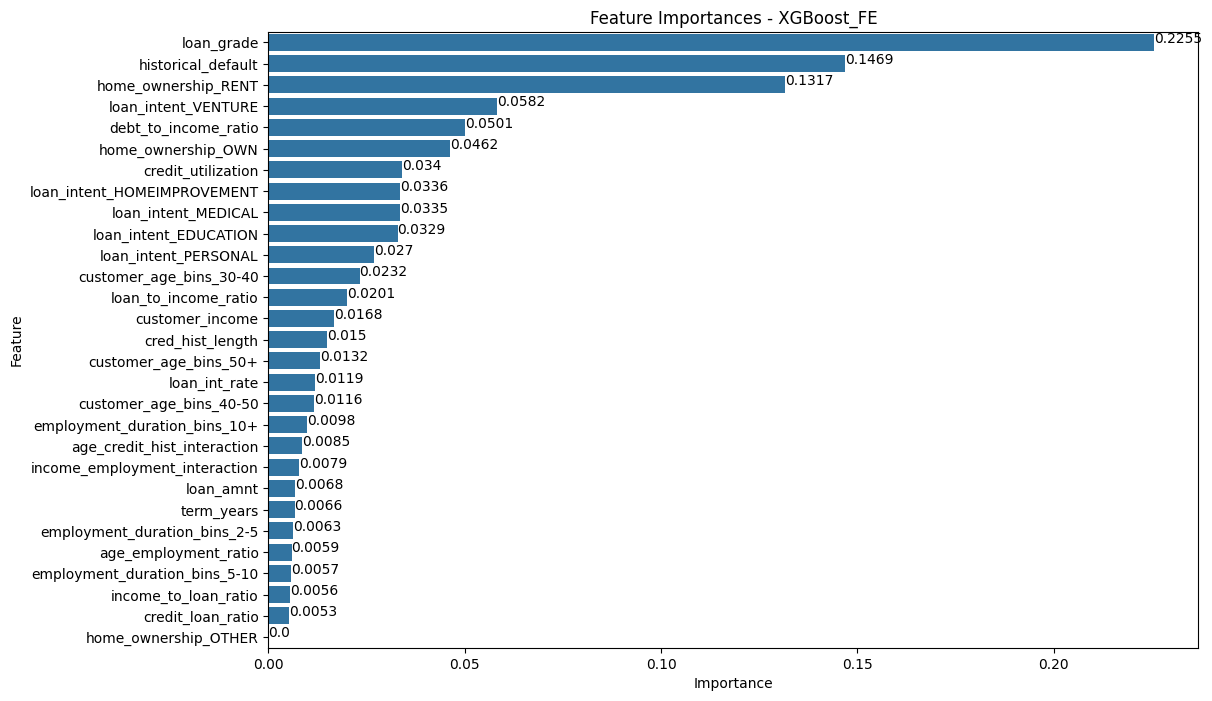

In [50]:
display_store_metrics(best_model_FE, results_df_FE, X_new, y_new)
display_features_importance(best_model_FE, best_model_name_FE, X_new, y_new)

**Matrix Consufion:** our new model reduced the false negative rate but in other hand it improved the true positives. The small decrease in false negative might suggest that our data doesn't show a pattern of  people who defaulted the loan since the loan status is imbalanced.

**Feature Importance:**
- Loan Garde, Historical Default and home_ownership remain the top indicator for predicting the defaulters.
- Our feature engineering helped a little bit since we see new features like `debt_to_income_ratio` and `credit_utilization` ranking in top 10 most important features

<b>Predicting the loan status for missing elements</b>

In [51]:
# Preprocess df_missing in the same way as your training data
df_missing_2_copy = df_missing_2.copy()
# Ensure df_missing has the same structure as your training DataFrame X
X_missing_2 = df_missing_2_copy.drop('current_loan_status', axis=1)

# Predict using the trained Random Forest model
df_missing_2_copy['current_loan_status_predicted'] = best_model_FE.predict(X_missing_2)

# Map encoded predictions back to original labels (0 -> 'NO DEFAULT', 1 -> 'DEFAULT')
df_missing_2_copy['current_loan_status_predicted'] = df_missing_2_copy['current_loan_status_predicted'].map({0: 'NO DEFAULT', 1: 'DEFAULT'})

# Display the DataFrame with predictions
print(df_missing_2_copy['current_loan_status_predicted'].head().T)


21791    NO DEFAULT
22076       DEFAULT
22742    NO DEFAULT
23069    NO DEFAULT
Name: current_loan_status_predicted, dtype: object


<a id="conclusion-and-recommendations"></a>
### Conclusion and Recommendations <div style="text-align: right; font-size: 13px;"><b><a href="#table_of_content" style="margin-right: 50px;"><i>Back</a></i></b></div>

<h4><b><u>Conclusion</u></b></h4>

- Loan grade is by far the strongest predictor of default risk, followed by previous default history.
- Home rental status, venture loan purposes, and high debt-to-income ratios are significant warning signs.
- Renters present higher default risks compared to homeowners.
- Surprisingly, loan amount and term length are less influential than many traditional factors.
- Venture funding loans carry significantly more risk than personal, medical, or educational loans.
- Age demonstrates some correlation with repayment behavior, with the 30-40 age group showing distinctive patterns.

Click on this <a href='<iframe title="credit_loan_defaulters-v3" width="600" height="373.5" src="https://app.powerbi.com/view?r=eyJrIjoiNjRjMzQ2ZjktMjU2MS00YWMwLTgxYWYtZDc1MDZkMzRmMGM4IiwidCI6IjhjY2M5ZDBkLTA3YmMtNDZlNS05NDg3LTUzNWFiYWY4N2ViMSJ9" frameborder="0" allowFullScreen="true"></iframe>'>link</a> to see a visual report.

<h4><b><u>Recommendations</u></b></h4>

**Lending Strategy:**

- Prioritize loan grade in approval decisions but verify it against actual default history.
- Consider charging higher interest rates for debt consolidation loans and applicants with rental housing status.
- Implement tiered pricing based on risk profiles rather than simple approve/deny decisions.


**Risk Management:**

- Increase verification requirements for high debt-to-income applicants.
- Develop special underwriting guidelines for debt consolidation loans.
- Create an early warning system for loans with multiple risk factors.


**Business Opportunities:**

- Develop specialized loan products for homeowners leveraging their lower default rates.
- Consider educational loan programs as they show lower default tendencies.
- Explore partnership opportunities with real estate companies to offer homebuyer programs that could convert renters to lower-risk homeowners.


**Customer Experience:**

- Offer financial education resources for borderline applicants.
- Create loyalty programs for repeat borrowers with good repayment history.
- Implement a "second chance" program for borrowers with improving credit profiles.


**Future Directions:**

- Test different interest rate structures based on risk levels to maximize profitability while maintaining reasonable approval rates.
- Explore early repayment incentives for higher-risk borrowers.
- Conduct regular review of lending criteria as economic conditions change.